# A Deep Learning based Malware Classification

# TABLE OF CONTENTS

# 1. Importing the required modules
# 2. Exploratory Data Analysis
# 3. Image Preprocessing
# 4. Domain Adaptation of CNN architectures
# 5. Experimentation of CNN architecture using Domain Adaptation
# 6. Model Evaluation
# 7. Model Exploration on the dataset
# 8. Saving the model related information
# 9. Model-wise Comparison
# 10. Dataset Comparison vs Imbalance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Importing the required modules

In [ ]:
!pip install split-folders

In [ ]:
# Module used for interacting with the file system.
import os
import json

# Modules used for data handling and manipulation
import pandas as pd
import numpy as np

# Modules used for data visualization
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid")

# Modules used for random number choice
import random as r

# Module used to split train-test split
import splitfolders

# Modules used for model training and transfer learning
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as cnns
from tensorflow.keras import Model

# For graph visualization
import networkx as nx
from networkx.algorithms import bipartite

# Modules used for model evaluation and selection.
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score

# Module for suppressing warnings.
import warnings
warnings.filterwarnings('ignore')

# Module used for Image transformations
import scipy

# Constants
malimg_dir = "/content/drive/MyDrive/malclassfolder/malimg_dataset"
malevis_dir = "/content/drive/MyDrive/malclassfolder/malevis_dataset"

The dataset includes directories for both training and validation, each containing images of different types of malware. However, we now need to divide the training data images into separate train and test datasets to assess the performance of the models being developed. To achieve this, a class is designed to accept three inputs: the dataset directory, the percentage of images for training, and the percentage of images for testing.

# Exploratory Data Analysis

In [ ]:
# A class for loading an image dataset and understanding its class distribution
# and image samples across classes.
class MalwareImages:

    # Initialize the dataset loader with the dataset path.
    def __init__(self, DATA_DIR : str, n : int):
        self.DATA_DIR = DATA_DIR
        self.class_distribution = dict()
        self.ROWS = n
        self.COLS = 5
        self.ROWS = (15 + self.COLS - 1) // self.COLS

    # Computation of the class distribution of the dataset.
    def __compute_class_distribution(self):
        for malware_type in os.listdir(self.DATA_DIR):
            malware_img_dir = os.path.join(self.DATA_DIR, malware_type)
            self.class_distribution[malware_type] = len(os.listdir(malware_img_dir))

    # Plotting the class distribution.
    def plot_class_distribution(self):
        self.__compute_class_distribution()

        malware_classes = list(self.class_distribution.keys())
        malware_class_frequency = list(self.class_distribution.values())
        color_palette = sns.color_palette("pastel")
        plt.figure(figsize=(8,8))
        sns.barplot(y = malware_classes,
                    x = malware_class_frequency,
                    palette = color_palette,
                    edgecolor = "black",
                    orient='h')
        plt.title("Malware Class Distribution", fontsize=16)
        plt.xlabel("Malware Class Frequency", fontsize=14)
        plt.ylabel("Malware Type", rotation=270, labelpad=20, fontsize=14)

    # Insights into samples of different malware images across different classes.
    def malware_samples(self):
        c = 0
        fig, axs = plt.subplots(self.ROWS, self.COLS, figsize=(10, 10))

        malware_types = os.listdir(self.DATA_DIR)
        total_samples = 15  # Set the total number of samples to 15

        for malware_type in malware_types:
            malware_img_dir = os.path.join(self.DATA_DIR, malware_type)
            malware_img_samples = list(os.listdir(malware_img_dir))
            if malware_img_samples:
                malware_img_sample = r.choice(malware_img_samples)
                malware_img_sample_path = os.path.join(malware_img_dir, malware_img_sample)
                image = mpimg.imread(malware_img_sample_path)
                row = c // self.COLS
                col = c % self.COLS
                axs[row, col].imshow(image, cmap="gray")
                axs[row, col].set_title(malware_type)
                c += 1
                if c >= total_samples:
                    break

        fig.suptitle("Sample for Malware types")
        plt.subplots_adjust(wspace=0.9)
        plt.show()



# **MalImg Dataset**

# Initialization of the Dataset Loader

In [ ]:
train_dataset = MalwareImages(os.path.join(malimg_dir, "train"),
                              5)


# Class Distribution

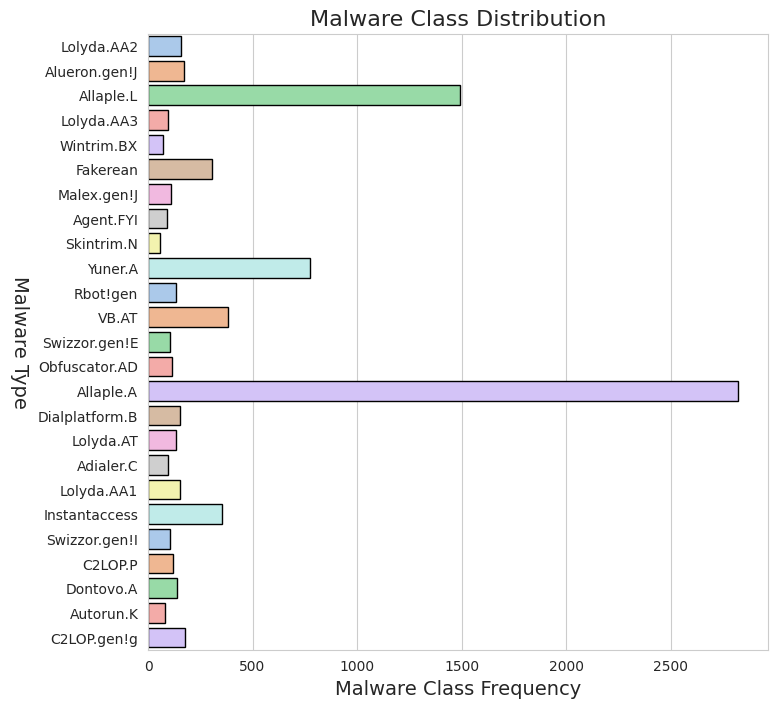

In [ ]:
train_dataset.plot_class_distribution()

# Malware Image Samples

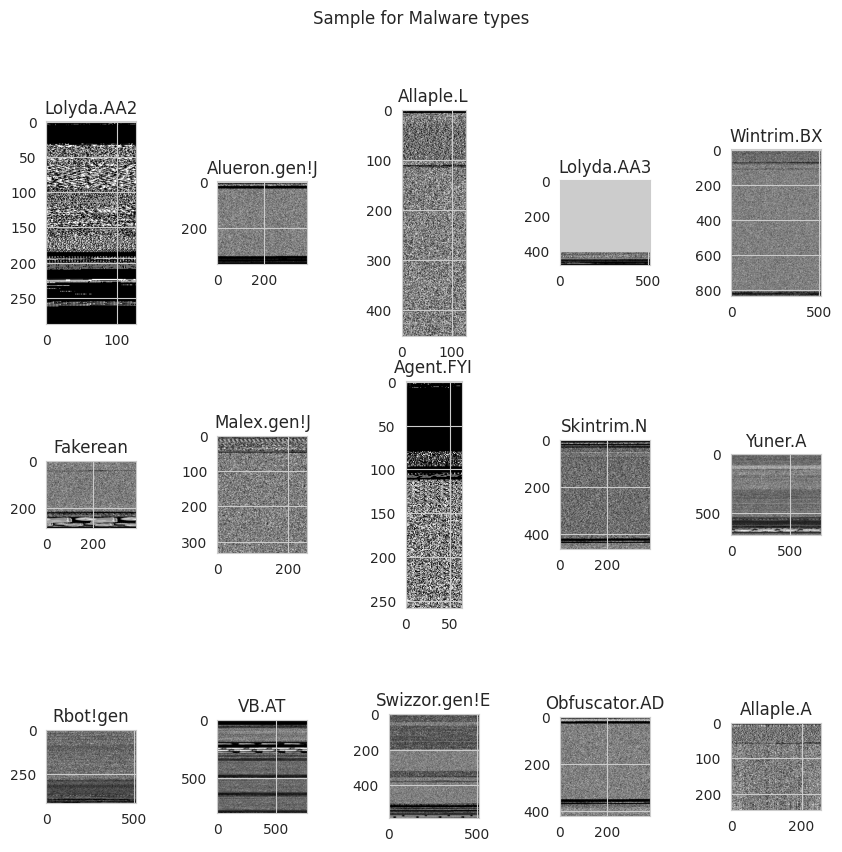

In [ ]:
train_dataset.malware_samples()


**Malevis Image Dataset**

Initialization of the dataset loader

In [ ]:
train_dataset_malevis = MalwareImages(os.path.join(malevis_dir, "train"),
                                      6)

Class Distribution

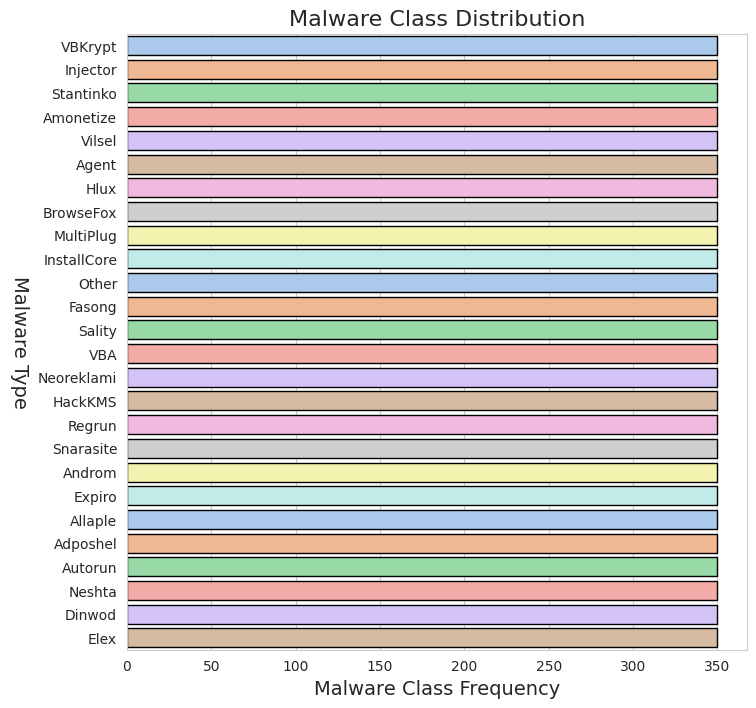

In [ ]:
train_dataset_malevis.plot_class_distribution()

Malware Image Samples

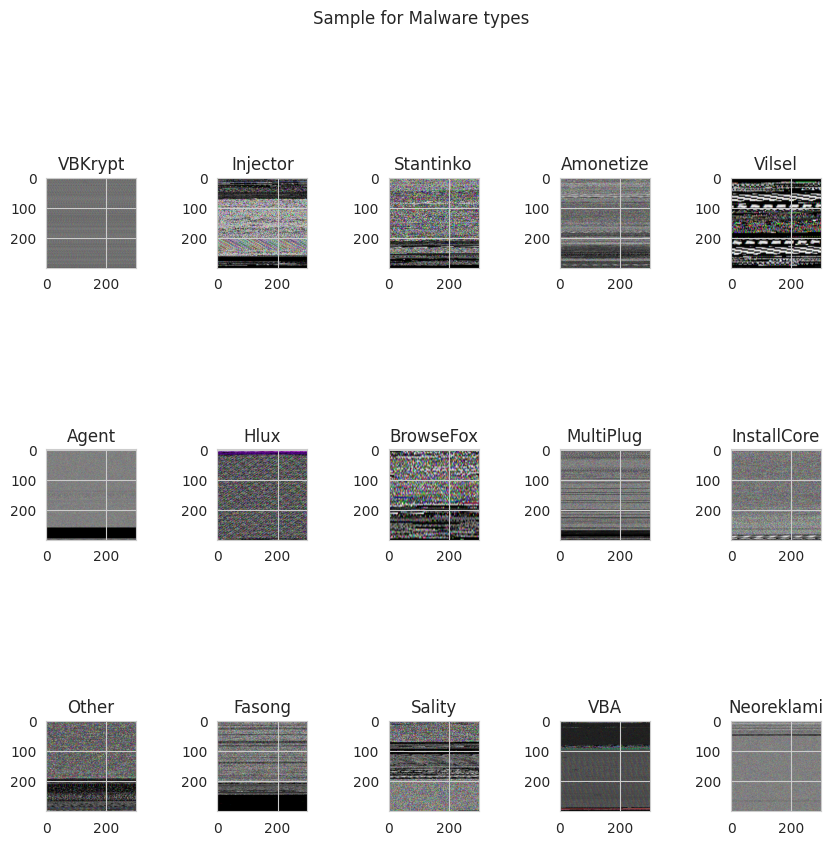

In [ ]:
train_dataset_malevis.malware_samples()

# Train-Test Split

In [ ]:
# Splitting the dataset into training and testing subsets proportionally.
def split_dataset(train_data_dir : str, dest_path : str, train_ratio : float, test_ratio : float):

    splitfolders.ratio(input = train_data_dir,
                       output = dest_path,
                       seed = 1337,
                       ratio = (train_ratio, 0, test_ratio),
                       group_prefix = None,
                       move = False)

Malimg Dataset

In [ ]:
split_dataset(os.path.join(malimg_dir,
                           "train"),
              "malimg/",
              0.8,
              0.2)



Copying files: 0 files [00:00, ? files/s]
Copying files: 5 files [00:00, 17.76 files/s]
Copying files: 30 files [00:00, 95.32 files/s]
Copying files: 66 files [00:00, 179.58 files/s]
Copying files: 97 files [00:00, 219.99 files/s]
Copying files: 132 files [00:00, 259.21 files/s]
Copying files: 162 files [00:00, 247.16 files/s]
Copying files: 190 files [00:01, 160.01 files/s]
Copying files: 217 files [00:01, 181.57 files/s]
Copying files: 242 files [00:01, 195.59 files/s]
Copying files: 275 files [00:01, 227.79 files/s]
Copying files: 302 files [00:01, 236.67 files/s]
Copying files: 333 files [00:01, 153.09 files/s]
Copying files: 354 files [00:10,  9.36 files/s] 
Copying files: 392 files [00:11, 14.88 files/s]
Copying files: 424 files [00:11, 21.19 files/s]
Copying files: 457 files [00:11, 30.10 files/s]
Copying files: 488 files [00:11, 41.16 files/s]
Copying files: 516 files [00:11, 53.58 files/s]
Copying files: 550 files [00:11, 73.71 files/s]
Copying files: 579 files [00:11, 92.43 

Malevis Dataset

In [ ]:
split_dataset(os.path.join(malevis_dir,
                           "train"),
              "malevis/",
              0.8,
              0.2)


Copying files: 0 files [00:00, ? files/s]
Copying files: 2 files [00:00,  3.90 files/s]
Copying files: 3 files [00:01,  2.81 files/s]
Copying files: 4 files [00:01,  2.51 files/s]
Copying files: 5 files [00:01,  2.33 files/s]
Copying files: 6 files [00:03,  1.41 files/s]
Copying files: 7 files [00:03,  1.47 files/s]
Copying files: 24 files [00:04, 11.72 files/s]
Copying files: 29 files [00:04, 11.78 files/s]
Copying files: 45 files [00:04, 19.18 files/s]
Copying files: 74 files [00:04, 42.60 files/s]
Copying files: 101 files [00:05, 67.59 files/s]
Copying files: 117 files [00:05, 56.54 files/s]
Copying files: 152 files [00:05, 90.24 files/s]
Copying files: 185 files [00:05, 124.85 files/s]
Copying files: 219 files [00:05, 161.22 files/s]
Copying files: 248 files [00:06, 92.51 files/s] 
Copying files: 275 files [00:06, 75.25 files/s]
Copying files: 300 files [00:07, 93.20 files/s]
Copying files: 319 files [00:07, 73.17 files/s]
Copying files: 351 files [00:07, 96.45 files/s]
Copying fi

# Image Preprocessing

In [ ]:
# A class to preprocess the malware images to make it usable for training neural networks.
class ImageProcessor:

    # Initialization of the image preprocessor with required file locations.
    def __init__(self, model, train_dir : str, test_dir : str, val_dir : str, size, colormode : str) -> None:
        self.cnn_variant = model
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None
        self.colormode = colormode
        self.TRAIN_DIR = train_dir
        self.TEST_DIR = test_dir
        self.VAL_DIR = val_dir
        self.size = size

    # Creating generators based on the preprocessing requirements of the CNN architecture.
    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input,
        )

        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )

        self.val_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )

    # Reading the images from the respective directories.
    def get_images(self):
        train_images = self.train_gen.flow_from_directory(
            directory=self.TRAIN_DIR,
            target_size=self.size,
            classes=sorted([i for i in os.listdir(self.TRAIN_DIR) if i != "Other"]),
            color_mode=self.colormode,
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42,
            subset='training',
        )

        val_images = self.val_gen.flow_from_directory(
            directory=self.VAL_DIR,
            target_size=self.size,
            classes=sorted([i for i in os.listdir(self.TRAIN_DIR) if i != "Other"]),
            color_mode=self.colormode,
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42
        )

        test_images = self.test_gen.flow_from_directory(
            directory=self.TEST_DIR,
            target_size=self.size,
            classes=sorted([i for i in os.listdir(self.TRAIN_DIR) if i != "Other"]),
            color_mode=self.colormode,
            class_mode='categorical',
            batch_size=32,
            shuffle=False,
            seed=42
        )

        return train_images, val_images, test_images

# Domain Adaptation of CNN architectures

In [ ]:
# A class to adapt the state of the art CNNs
# for the classification of malware images.
class FineTuning:

    # Initialization of the Domain Adaptation process with required parameters.
    def __init__(self, train, val, model, class_count : int, regularize : bool, patience : int) -> None:
        self.train = train
        self.val = val
        self.model = model
        self.history = None
        self.fine_tune_from = 100
        self.CLASSES = class_count
        self.regularize = regularize
        self.patience = patience

    # Marking layers trainable or not.
    def fine_tune(self):
        for layer in self.model.layers[:self.fine_tune_from]:
            layer.trainable = False

        for layer in self.model.layers[self.fine_tune_from:]:
            layer.trainable = True

    # Addition of the final layer to the model with or without regularization.
    def add_final_layer(self):
        self.x = Flatten()(self.model.output)
        if self.regularize == True:
            self.x = Dense(2000, activation='relu')(self.x)
            self.x = Dropout(0.6)(self.x)
            self.x = Dense(1400, activation='relu')(self.x)
            self.x = Dropout(0.5)(self.x)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(self.CLASSES, activation = 'softmax')(self.x)

    # Compilation of the model with all the metrics, optimizer, and loss functions.
    def compile_model(self):
        self.model = Model(inputs = self.model.input, outputs = self.predictions)
        self.model.compile(optimizer='adam', loss="categorical_crossentropy",
                           metrics=['accuracy',
                                    tf.keras.metrics.AUC(name="auc",from_logits=True),
                                    tf.keras.metrics.FalsePositives(name="false_positives"),
                                    tf.keras.metrics.Precision(name="precision"),
                                    tf.keras.metrics.Recall(name="recall")])

    # Training the model with Early Stopping Criterion
    # on Validation Loss.
    def train_model(self):
        self.history = self.model.fit(self.train,
                                      batch_size=32,
                                      epochs=80,
                                      validation_data=self.val,
                                      callbacks=[
                                        tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=self.patience,
                                            restore_best_weights=True
                                        )
                                     ])

# Experimentation of CNN architecture using Domain Adaptation

In [ ]:
# Experimentation of a CNN architecture on the datasets using Domain Adaptation.
def experiment_model(preprocess_fx, new_data_dir : str,orig_data_dir : str, size, model, nclasses : int, val_dir : str, regularize : bool, patience : int):
    # Preprocessing the images.
    img = ImageProcessor(preprocess_fx,
                     os.path.join(new_data_dir, "train"),
                     os.path.join(new_data_dir, "test"),
                     os.path.join(orig_data_dir, val_dir),
                     size,
                     "rgb")
    img.create_generators()
    train, val, test = img.get_images()

    # Domain Adaptation of the CNN architecture.
    learner = FineTuning(train, val,
                         model, nclasses,
                         regularize, patience)
    learner.fine_tune()
    learner.add_final_layer()
    learner.compile_model()
    learner.train_model()

    # Returning the model, its training history, and
    # preprocessed test data for model evaluation.
    return learner.model, learner.history, test

# Model Evaluation

In [ ]:
# A class for the evaluating any Multiclass Classifier.
class ModelEvaluator:

    # Initialization of the evaluator with the model,
    # its training history, and preprocessed test data.
    def __init__(self, history, classes : list, model, test):
        self.history = history
        self.model = model
        self.test = test
        self.classes = classes
        self.num_classes = len(self.classes)
        self.predictions = None

    # Plotting the comparison of the performance on train and validation data.
    # based on a particular metric.
    def __plot_metric(self, ax, metric: str,train_metric : str, val_metric : str):

        ax.plot(self.history.history[train_metric])
        ax.plot(self.history.history[val_metric])


        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.title())
        ax.legend(['Train','Val'])

    # Plotting the overall training history.
    def training_history(self):
        rows = 2
        columns = 1
        c = 0
        metrics = ["accuracy", "loss"]

        fig, axs = plt.subplots(rows, columns,figsize=(10,10))
        for metric in metrics:
            self.__plot_metric(axs[c],
                               metric.replace("_", " ").title(),
                               metric, "val_"+metric)
            c += 1

        fig.suptitle("Training History of the Model")
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)
        plt.show()

    # Fetching the predictions from the model and its post processing.
    def predict(self):
        self.predictions = self.model.predict(self.test)
        self.predictions = list(map(np.argmax, self.predictions))

    # Displaying the classification report and Confusion Matrix.
    def class_report(self):
        plt.figure(figsize=(10,10))
        sns.heatmap(tf.math.confusion_matrix(self.test.labels, self.predictions, num_classes=len(self.classes)),
                    annot=False, cmap="crest" , cbar=False)
        plt.xlabel("Predicted Label", fontsize=16)
        plt.ylabel("True Label", fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)


        plt.show()

        print(classification_report(self.test.labels, self.predictions, target_names=self.classes))

# Model Exploration on the two datasets

In [ ]:
malimg_models = dict()
malevis_models = dict()


# XceptionNet


Malimg Dataset

Model Training

In [ ]:
import scipy

model, history, test = experiment_model(cnns.xception,
                                        "malimg",
                                        malimg_dir,
                                        (75, 75),
                                        cnns.Xception(include_top=False,
                                                      input_shape=(75, 75, 3)),
                                        25, "validation",
                                        False, 3)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Found 6711 images belonging to 25 classes.
Found 910 images belonging to 25 classes.
Found 1693 images belonging to 25 classes.
Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.4496 - auc: 0.8530 - false_positives: 581.7441 - loss: 2.1253 - precision: 0.6058 - recall: 0.2817 - val_accuracy: 0.5077 - val_auc: 0.9245 - val_false_positives: 260.0000 - val_loss: 1.5791 - val_precision: 0.6254 - val_recall: 0.4769
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.7781 - auc: 0.9879 - false_positives: 510.0806 - loss: 0.6023 - precision: 0.8245 - recall: 0.7381 - val_accuracy: 0.7967 - val_auc: 0.9868 - val_false_positives: 113.0000 - val_loss: 0.5912 - val_precision: 0.8575 - val_recall: 0.7473
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.8663 - auc: 0.9937 - false_positives: 362.4787 - loss: 0.3676 - precision: 0.8885 - recall: 0.8468 - val_accuracy: 0.8154 - val_auc: 0.9935 - val_

# Model Evaluation

Initialization of evaluator

In [ ]:
 me = ModelEvaluator(history,
                    list(test.class_indices.keys()),
                    model, test)


Training History

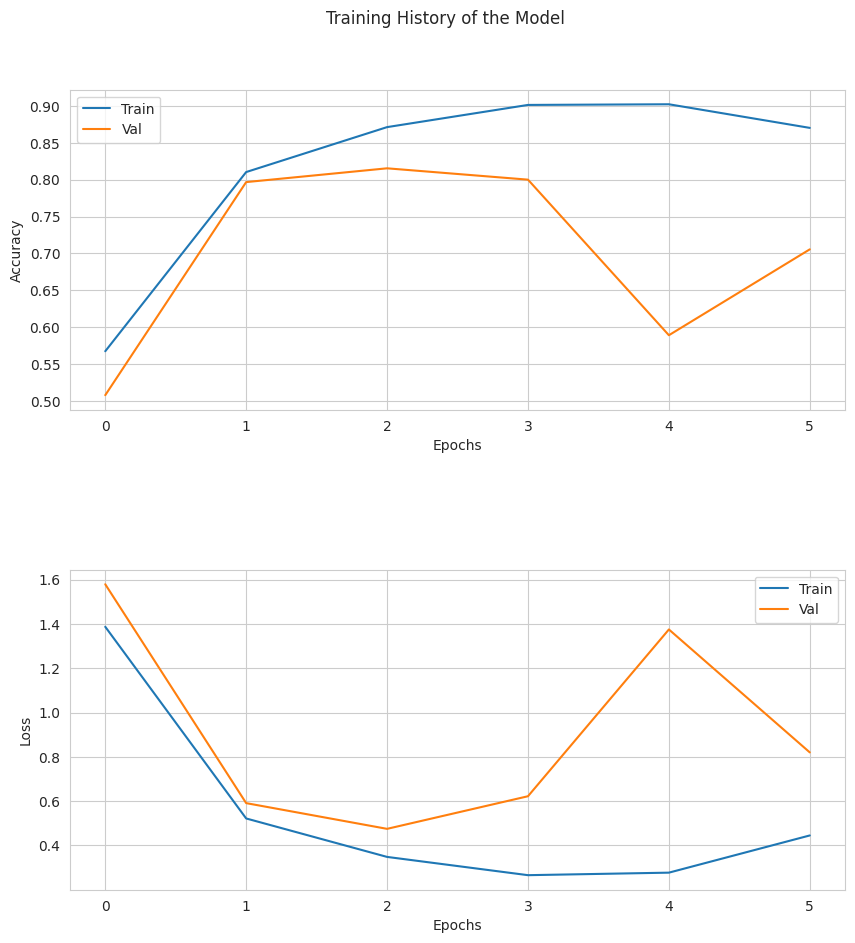

In [ ]:
me.training_history()

Classification Metrics

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step


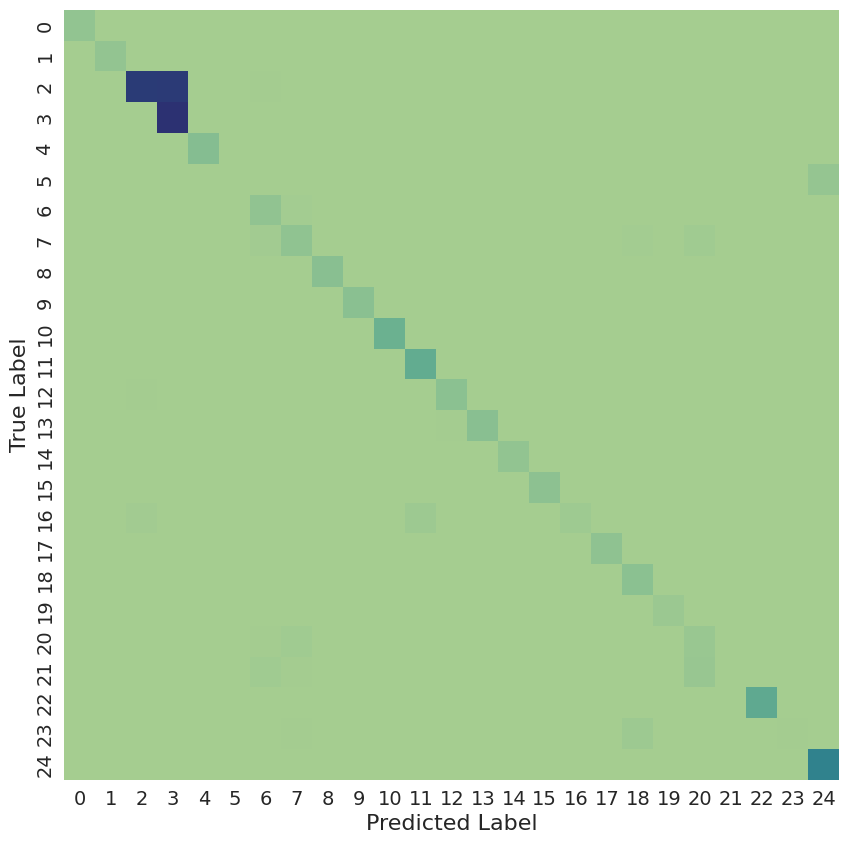

                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        20
     Agent.FYI       1.00      1.00      1.00        19
     Allaple.A       0.97      0.50      0.66       565
     Allaple.L       0.51      0.99      0.68       299
 Alueron.gen!J       1.00      0.97      0.99        35
     Autorun.K       0.00      0.00      0.00        17
       C2LOP.P       0.60      0.84      0.70        25
   C2LOP.gen!g       0.64      0.66      0.65        35
Dialplatform.B       1.00      0.97      0.98        31
     Dontovo.A       1.00      1.00      1.00        28
      Fakerean       1.00      1.00      1.00        62
 Instantaccess       0.88      1.00      0.94        72
    Lolyda.AA1       0.93      0.87      0.90        31
    Lolyda.AA2       1.00      0.94      0.97        32
    Lolyda.AA3       1.00      1.00      1.00        20
     Lolyda.AT       0.96      0.96      0.96        27
   Malex.gen!J       0.89      0.35      0.50  

In [ ]:
me.predict()
me.class_report()

Saving essential data

In [ ]:
malimg_models["XceptionNet"] = {"Ground Truth": test.labels.tolist(),
                                "Predictions":np.array(me.predictions).tolist(),
                                "History": history.history}

Malevis Dataset

Model training

In [ ]:
model, history, test = experiment_model(cnns.xception,
                                        "malevis",malevis_dir,
                                        (200, 200),
                                        cnns.Xception(include_top=False,
                                                      input_shape=(200, 200, 3)),
                                        25, "val",
                                        False, 8)

Found 7000 images belonging to 25 classes.
Found 3644 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.
Epoch 1/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 1750s 8s/step - accuracy: 0.4799 - auc: 0.8472 - false_positives: 180.8091 - loss: 2.3885 - precision: 0.8430 - recall: 0.3799 - val_accuracy: 0.8658 - val_auc: 0.9867 - val_false_positives: 151.0000 - val_loss: 0.5117 - val_precision: 0.9518 - val_recall: 0.8181
Epoch 2/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 58s 263ms/step - accuracy: 0.8177 - auc: 0.9752 - false_positives: 260.0864 - loss: 0.8272 - precision: 0.9048 - recall: 0.7457 - val_accuracy: 0.8403 - val_auc: 0.9592 - val_false_positives: 382.0000 - val_loss: 1.0452 - val_precision: 0.8855 - val_recall: 0.8106
Epoch 3/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 61s 276ms/step - accuracy: 0.8943 - auc: 0.9894 - false_positives: 199.5682 - loss: 0.5364 - precision: 0.9426 - recall: 0.8643 - val_accuracy: 0.8436 - val_auc: 0.9649 - val_false_positives: 313.0000 - val_loss: 1.5575 - 

Model Evaluation

Initialization of Evaluator

In [ ]:
me = ModelEvaluator(history,
                    list(test.class_indices.keys()),
                    model, test)


Training History

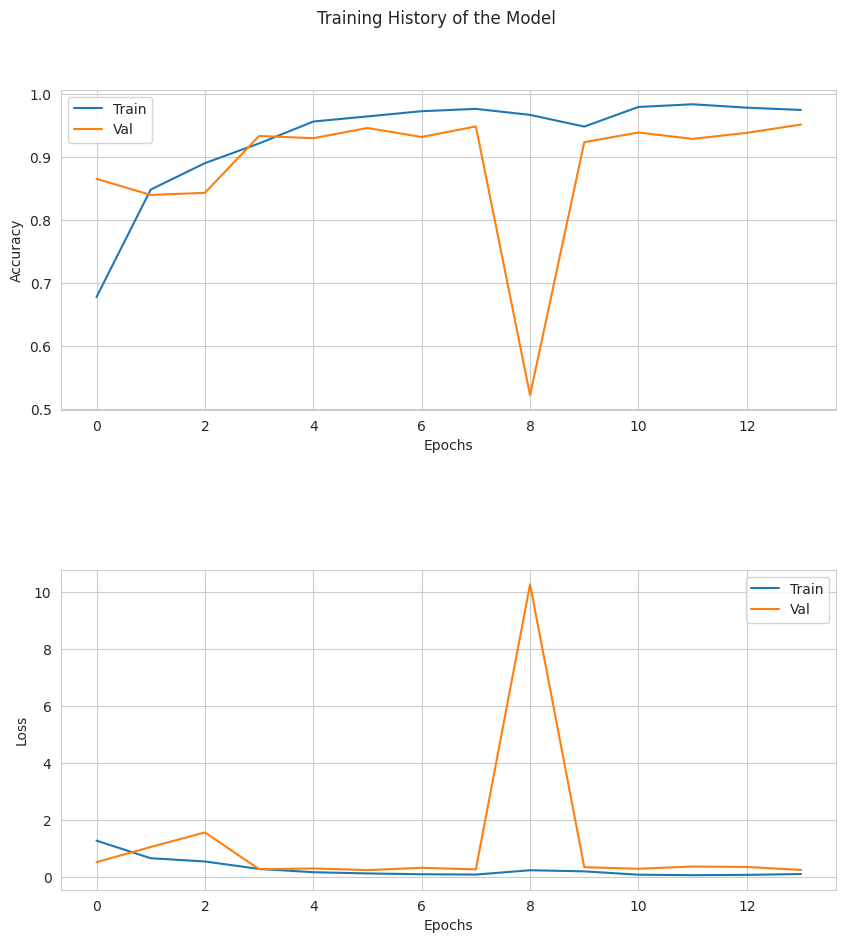

In [ ]:
me.training_history()

Classification Metrics

55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 244ms/step


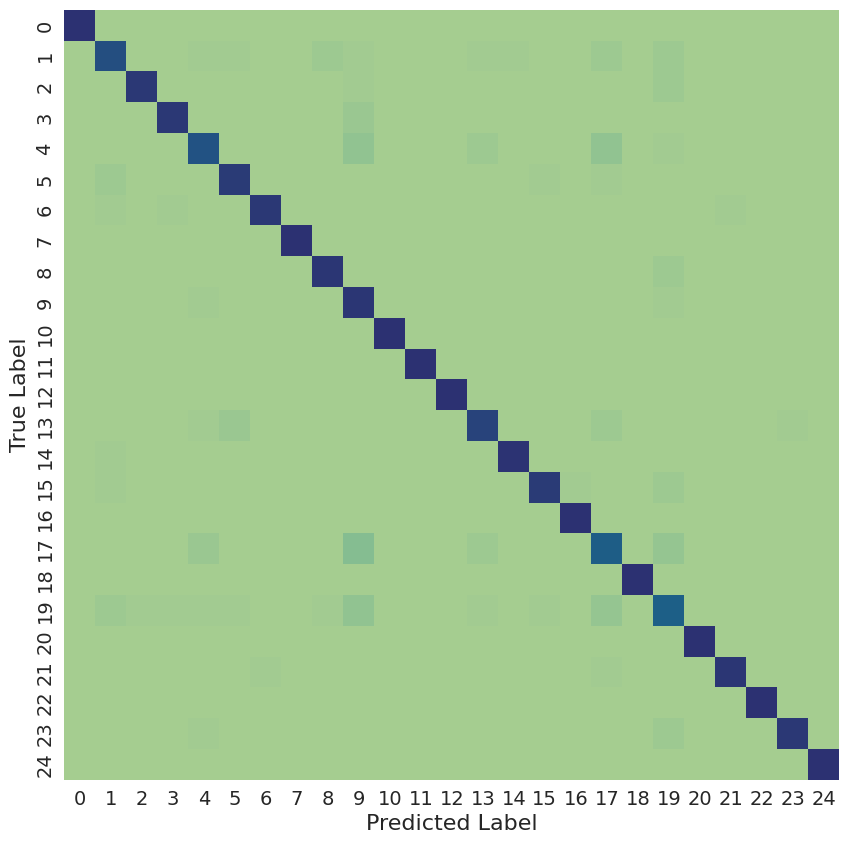

              precision    recall  f1-score   support

    Adposhel       1.00      1.00      1.00        70
       Agent       0.89      0.84      0.87        70
     Allaple       0.99      0.96      0.97        70
   Amonetize       0.97      0.96      0.96        70
      Androm       0.88      0.81      0.84        70
     Autorun       0.93      0.94      0.94        70
   BrowseFox       0.99      0.96      0.97        70
      Dinwod       1.00      1.00      1.00        70
        Elex       0.96      0.97      0.96        70
      Expiro       0.75      0.97      0.84        70
      Fasong       1.00      1.00      1.00        70
     HackKMS       1.00      1.00      1.00        70
        Hlux       1.00      1.00      1.00        70
    Injector       0.91      0.90      0.91        70
 InstallCore       0.99      0.99      0.99        70
   MultiPlug       0.97      0.94      0.96        70
  Neoreklami       0.99      1.00      0.99        70
      Neshta       0.78    

In [ ]:
me.predict()
me.class_report()

Saving Essential data

In [ ]:
malevis_models["XceptionNet"] = {"Ground Truth": test.labels.tolist(),
                                 "Predictions":np.array(me.predictions).tolist(),
                                 "History": history.history}


# EfficientNetB0

Malimg Dataset

Model Training

In [ ]:
model, history, test = experiment_model(cnns.efficientnet,
                                        "malimg",malimg_dir,
                                        (75, 75),
                                        cnns.EfficientNetB0(include_top=False,
                                                            input_shape=(75, 75, 3)),
                                        25, "validation",
                                        False, 3)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 6711 images belonging to 25 classes.
Found 910 images belonging to 25 classes.
Found 1693 images belonging to 25 classes.
Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 89s 224ms/step - accuracy: 0.7386 - auc: 0.9487 - false_positives: 550.9005 - loss: 1.0965 - precision: 0.7833 - recall: 0.7124 - val_accuracy: 0.9044 - val_auc: 0.9898 - val_false_positives: 77.0000 - val_loss: 0.3584 - val_precision: 0.9139 - val_recall: 0.8978
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.9305 - auc: 0.9946 - false_positives: 211.0047 - loss: 0.2321 - precision: 0.9374 - recall: 0.9238 - val_accuracy: 0.9132 - val_auc: 0.9948 - val_false_positives: 70.0000 - val_loss: 0.2233 - val_precision: 0.9219 - val_recall: 0.9077
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step - accuracy: 0.9283 - auc: 0.9939 - false_positives: 224.7630 - loss: 0.2367 - precision: 0.9373 - recall: 0.9222 - val_accuracy: 0.8055 - val_auc: 0.9510 - val_

# Model Evaluation

Initialization of the Evaluator

In [ ]:
me = ModelEvaluator(history,
                    list(test.class_indices.keys()),
                    model, test)

Training History

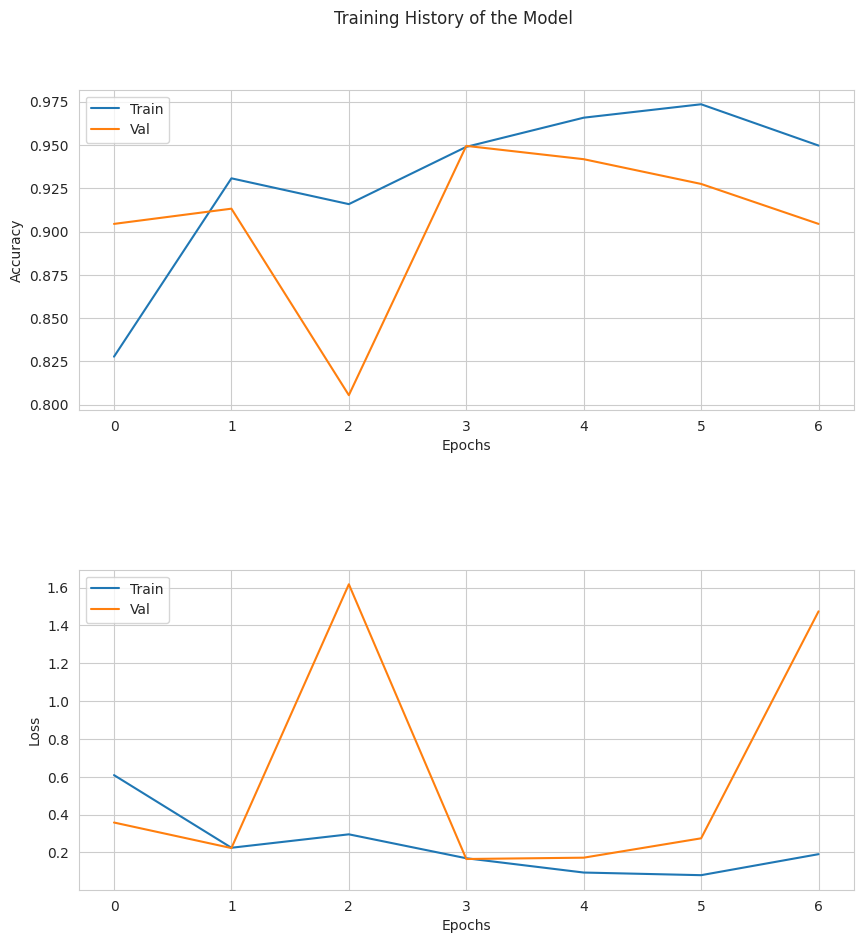

In [ ]:
me.training_history()

Classification Metrics

53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step


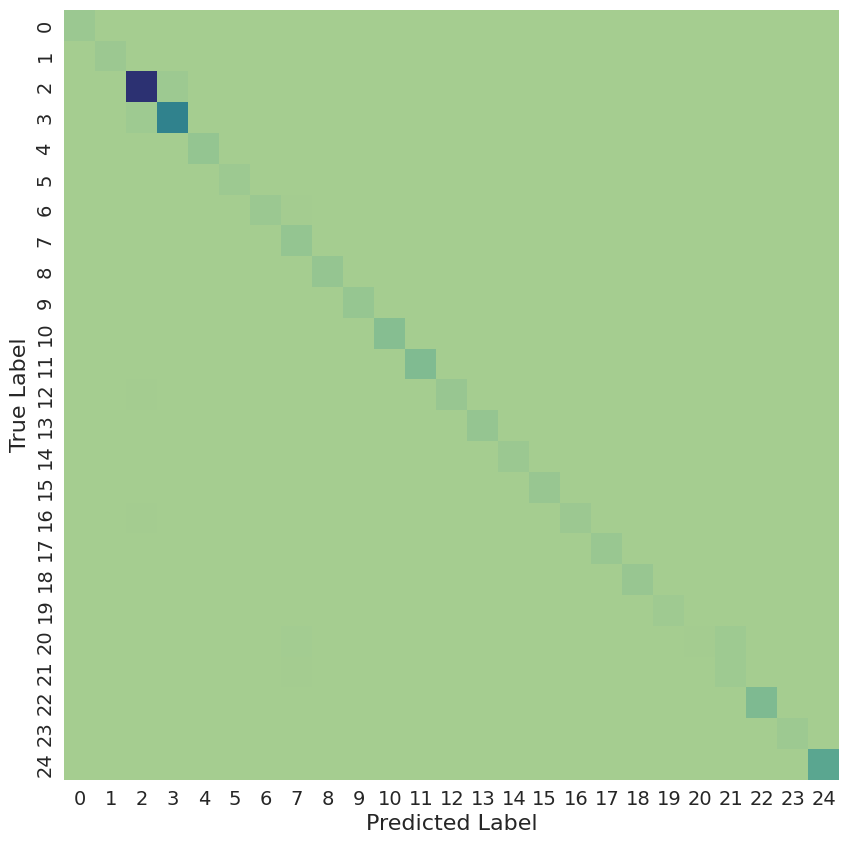

                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        20
     Agent.FYI       1.00      1.00      1.00        19
     Allaple.A       0.96      0.97      0.97       565
     Allaple.L       0.95      0.96      0.95       299
 Alueron.gen!J       1.00      0.97      0.99        35
     Autorun.K       1.00      1.00      1.00        17
       C2LOP.P       0.88      0.84      0.86        25
   C2LOP.gen!g       0.74      0.97      0.84        35
Dialplatform.B       1.00      0.97      0.98        31
     Dontovo.A       1.00      1.00      1.00        28
      Fakerean       0.97      1.00      0.98        62
 Instantaccess       1.00      1.00      1.00        72
    Lolyda.AA1       0.90      0.87      0.89        31
    Lolyda.AA2       1.00      0.94      0.97        32
    Lolyda.AA3       1.00      1.00      1.00        20
     Lolyda.AT       1.00      1.00      1.00        27
   Malex.gen!J       1.00      0.83      0.90  

In [ ]:
me.predict()
me.class_report()

Saving essential data

In [ ]:
malimg_models["EfficientNetB0"] = {"Ground Truth": test.labels.tolist(),
                                   "Predictions":np.array(me.predictions).tolist(),
                                   "History": history.history}

Malevis Dataset


Model Training

In [ ]:
model, history, test = experiment_model(cnns.efficientnet,
                                        "malevis",malevis_dir,
                                        (200,200),
                                        cnns.EfficientNetB0(include_top=False,
                                                            input_shape=(200, 200, 3)),
                                        25, "val",
                                        False, 8)

Found 7000 images belonging to 25 classes.
Found 3644 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.
Epoch 1/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 130s 370ms/step - accuracy: 0.7869 - auc: 0.9386 - false_positives: 379.4818 - loss: 1.5936 - precision: 0.8391 - recall: 0.7662 - val_accuracy: 0.9155 - val_auc: 0.9908 - val_false_positives: 173.0000 - val_loss: 0.3277 - val_precision: 0.9500 - val_recall: 0.9012
Epoch 2/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.9278 - auc: 0.9902 - false_positives: 190.7955 - loss: 0.3221 - precision: 0.9467 - recall: 0.9171 - val_accuracy: 0.9155 - val_auc: 0.9856 - val_false_positives: 230.0000 - val_loss: 0.4238 - val_precision: 0.9351 - val_recall: 0.9092
Epoch 3/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.9409 - auc: 0.9913 - false_positives: 165.8864 - loss: 0.2992 - precision: 0.9587 - recall: 0.9348 - val_accuracy: 0.5554 - val_auc: 0.8117 - val_false_positives: 1549.0000 - val_loss: 10.248

Model Evaluation

*Initialization of the Evaluator*

In [ ]:
me = ModelEvaluator(history,
                    list(test.class_indices.keys()),
                    model, test)

Training History

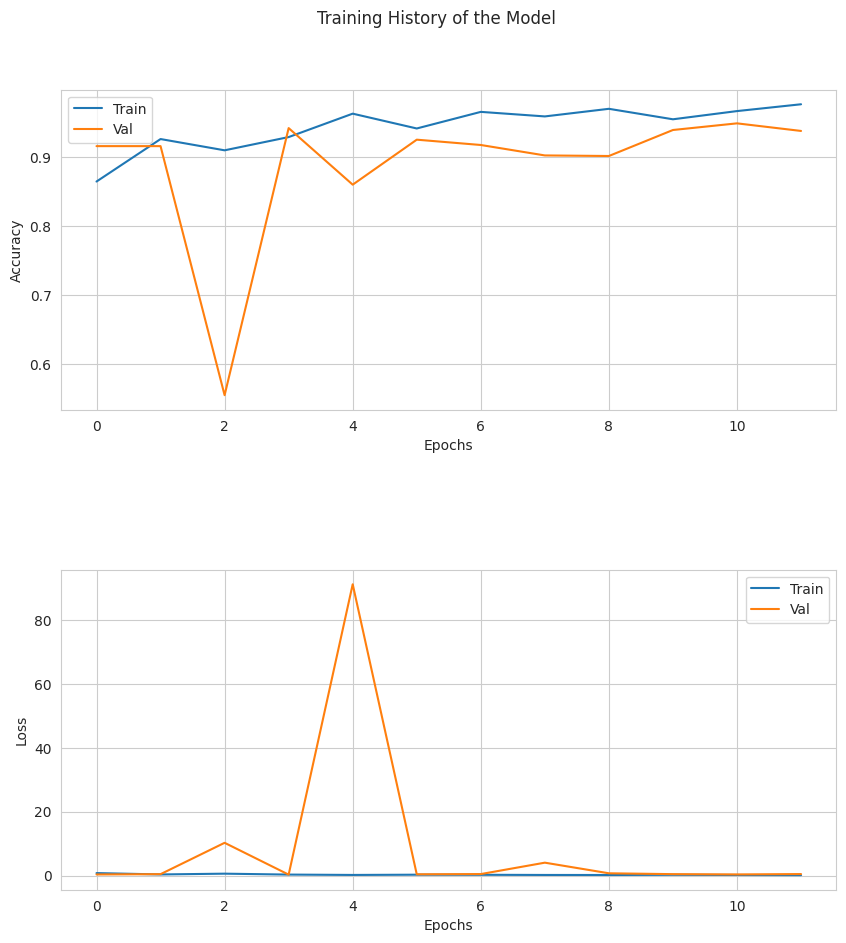

In [ ]:
me.training_history()


Classification Metrics

55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 230ms/step


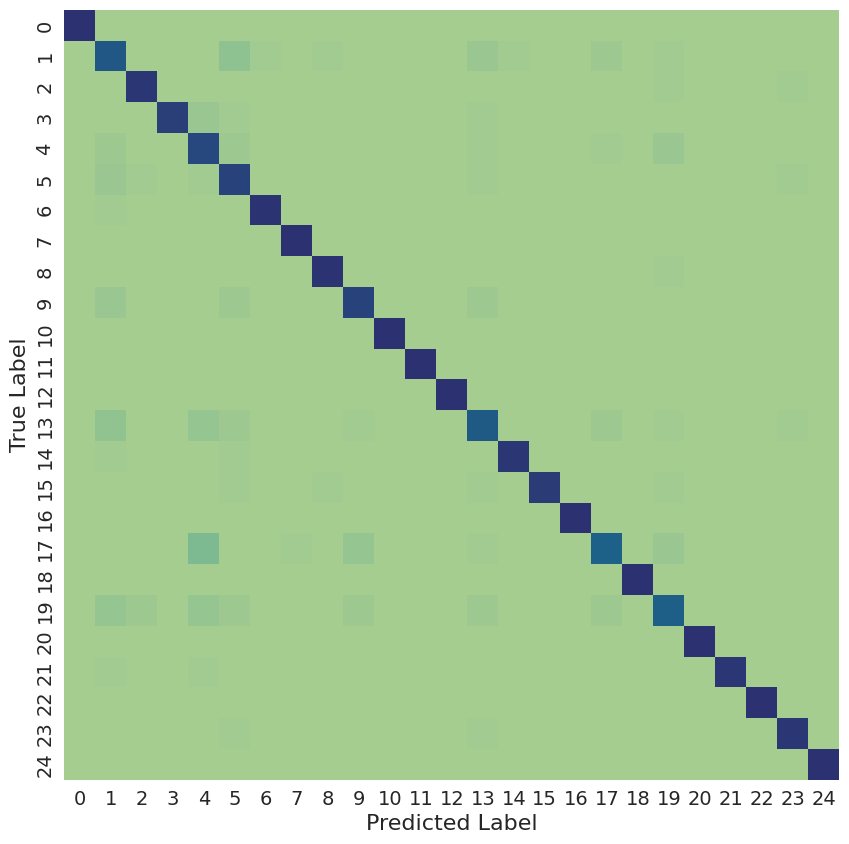

              precision    recall  f1-score   support

    Adposhel       1.00      1.00      1.00        70
       Agent       0.73      0.79      0.76        70
     Allaple       0.96      0.97      0.96        70
   Amonetize       1.00      0.93      0.96        70
      Androm       0.73      0.87      0.79        70
     Autorun       0.78      0.90      0.83        70
   BrowseFox       0.99      0.99      0.99        70
      Dinwod       0.99      1.00      0.99        70
        Elex       0.97      0.99      0.98        70
      Expiro       0.90      0.90      0.90        70
      Fasong       1.00      1.00      1.00        70
     HackKMS       1.00      1.00      1.00        70
        Hlux       1.00      1.00      1.00        70
    Injector       0.81      0.77      0.79        70
 InstallCore       0.99      0.97      0.98        70
   MultiPlug       1.00      0.94      0.97        70
  Neoreklami       1.00      1.00      1.00        70
      Neshta       0.88    

In [ ]:
me.predict()
me.class_report()

Saving essential data

In [ ]:
malevis_models["EfficientNetB0"] = {"Ground Truth": test.labels.tolist(),
                                    "Predictions":np.array(me.predictions).tolist(),
                                    "History": history.history}


# ResNet50

Malimg Dataset

Model Training

In [ ]:
model, history, test = experiment_model(cnns.resnet,
                                        "malimg",malimg_dir,
                                        (75,75),
                                        cnns.ResNet50(include_top=False,
                                                      input_shape=(75, 75, 3)),
                                        25, "validation",
                                        False, 3)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Found 6711 images belonging to 25 classes.
Found 910 images belonging to 25 classes.
Found 1693 images belonging to 25 classes.
Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 63s 173ms/step - accuracy: 0.6997 - auc: 0.9430 - false_positives: 574.8010 - loss: 2.4185 - precision: 0.7590 - recall: 0.6564 - val_accuracy: 0.6813 - val_auc: 0.9091 - val_false_positives: 246.0000 - val_loss: 22.4635 - val_precision: 0.7099 - val_recall: 0.6615
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.9283 - auc: 0.9946 - false_positives: 211.2938 - loss: 0.2121 - precision: 0.9346 - recall: 0.9238 - val_accuracy: 0.9220 - val_auc: 0.9971 - val_false_positives: 58.0000 - val_loss: 0.1898 - val_precision: 0.9353 - val_recall: 0.9220
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.9578 - auc: 0.9981 - false_positives: 136.4171 - loss: 0.1376 - precision: 0.9604 - recall: 0.9542 - val_accuracy: 0.8143 - val_auc: 0.9573 - va

# Model Evaluation

Initialization of the evaluator

In [ ]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

Training History

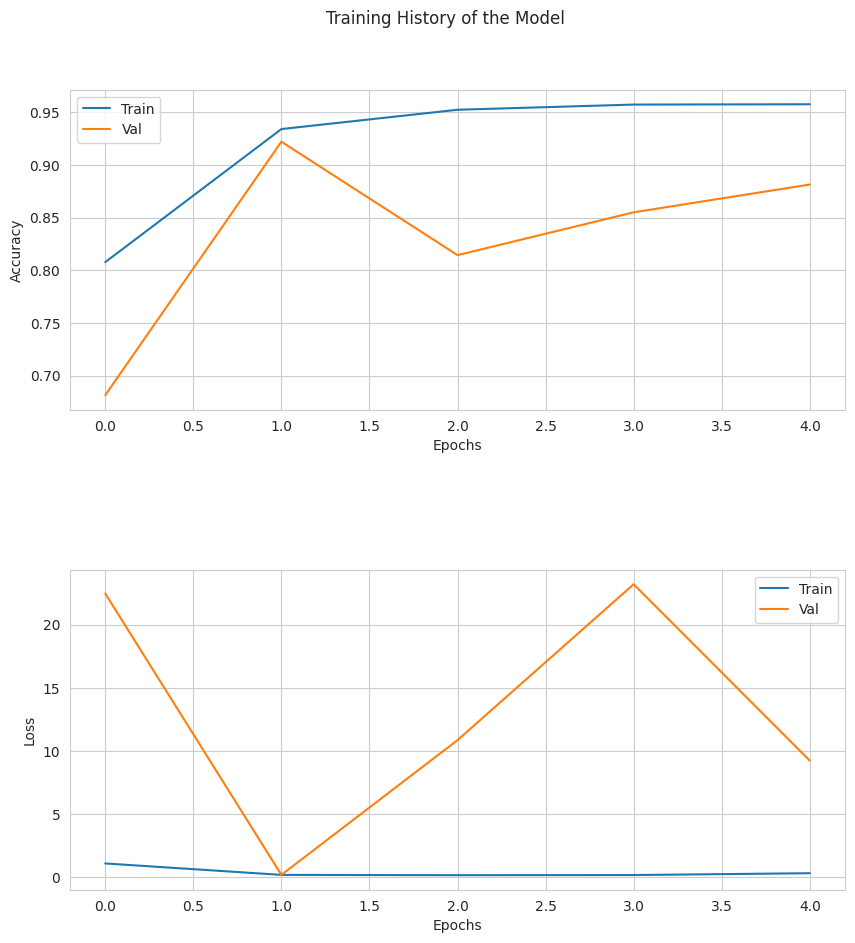

In [ ]:
me.training_history()

Classification Metrics

53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step


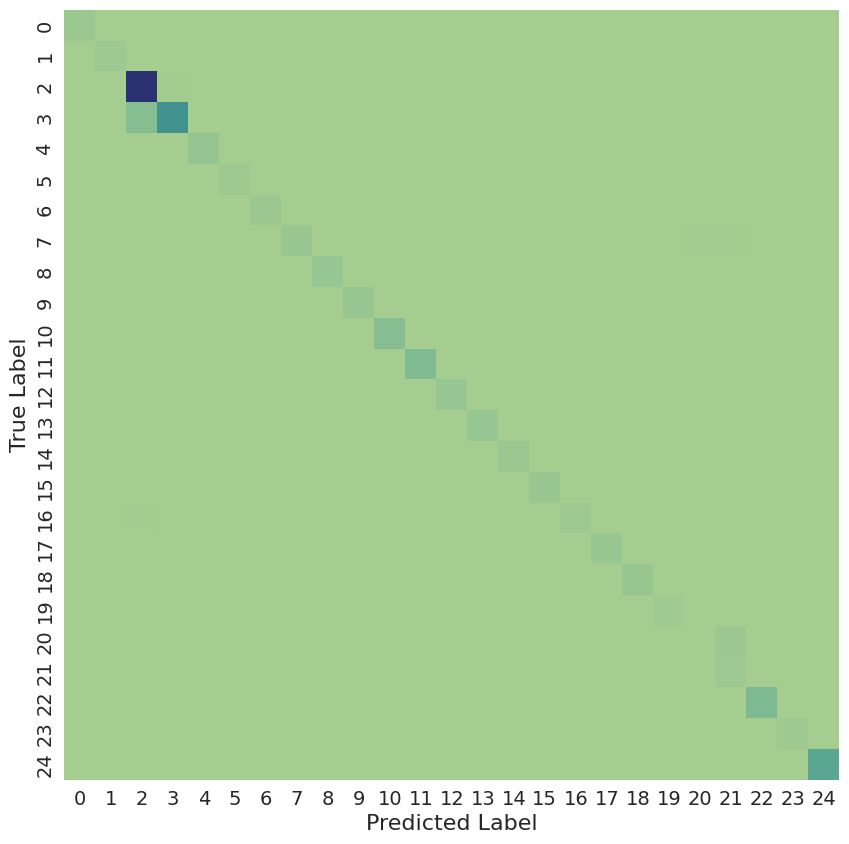

                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        20
     Agent.FYI       1.00      1.00      1.00        19
     Allaple.A       0.89      0.99      0.93       565
     Allaple.L       0.98      0.79      0.87       299
 Alueron.gen!J       0.97      0.94      0.96        35
     Autorun.K       1.00      1.00      1.00        17
       C2LOP.P       0.91      0.84      0.88        25
   C2LOP.gen!g       0.93      0.74      0.83        35
Dialplatform.B       1.00      0.97      0.98        31
     Dontovo.A       1.00      1.00      1.00        28
      Fakerean       1.00      1.00      1.00        62
 Instantaccess       0.99      1.00      0.99        72
    Lolyda.AA1       0.94      0.97      0.95        31
    Lolyda.AA2       1.00      0.94      0.97        32
    Lolyda.AA3       1.00      1.00      1.00        20
     Lolyda.AT       1.00      0.96      0.98        27
   Malex.gen!J       1.00      0.74      0.85  

In [ ]:
me.predict()
me.class_report()

Saving essential data

In [ ]:
malimg_models["ResNet50"] = {"Ground Truth": test.labels.tolist(),
                             "Predictions":np.array(me.predictions).tolist(),
                             "History": history.history}

Malevis Dataset

Model Training

In [ ]:
model, history, test = experiment_model(cnns.resnet,
                                        "malevis",malevis_dir,
                                        (200,200),
                                        cnns.ResNet50(include_top=False,
                                                      input_shape=(200, 200, 3)),
                                        25, "val",
                                        False, 8)

Found 7000 images belonging to 25 classes.
Found 3644 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.
Epoch 1/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 114s 370ms/step - accuracy: 0.7058 - auc: 0.9136 - false_positives: 306.3364 - loss: 6.1391 - precision: 0.8298 - recall: 0.6187 - val_accuracy: 0.8710 - val_auc: 0.9824 - val_false_positives: 328.0000 - val_loss: 0.5122 - val_precision: 0.9051 - val_recall: 0.8581
Epoch 2/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 58s 263ms/step - accuracy: 0.9439 - auc: 0.9903 - false_positives: 144.0773 - loss: 0.4726 - precision: 0.9589 - recall: 0.9279 - val_accuracy: 0.8650 - val_auc: 0.9690 - val_false_positives: 400.0000 - val_loss: 1.1555 - val_precision: 0.8808 - val_recall: 0.8112
Epoch 3/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 58s 262ms/step - accuracy: 0.9692 - auc: 0.9954 - false_positives: 91.8091 - loss: 0.2317 - precision: 0.9770 - recall: 0.9628 - val_accuracy: 0.9210 - val_auc: 0.9847 - val_false_positives: 239.0000 - val_loss: 0.5401 -

Model Evaluation

*Initialization of evaluator*

In [ ]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)


Training History

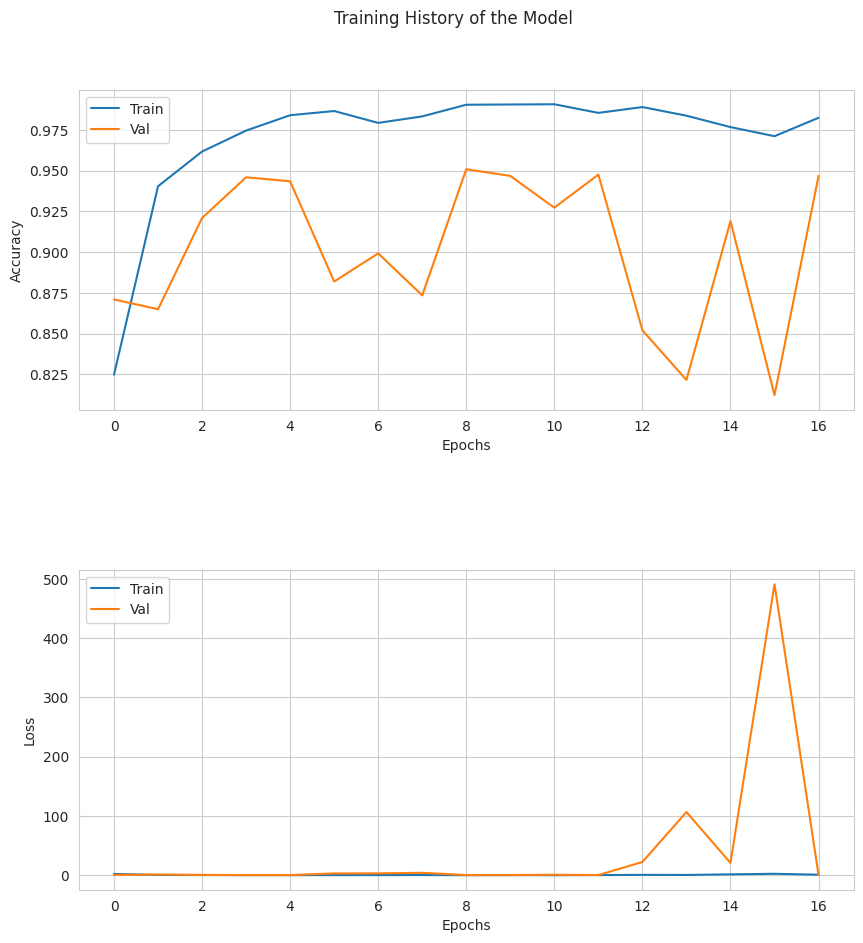

In [ ]:
me.training_history()


Classification Metrics

55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step


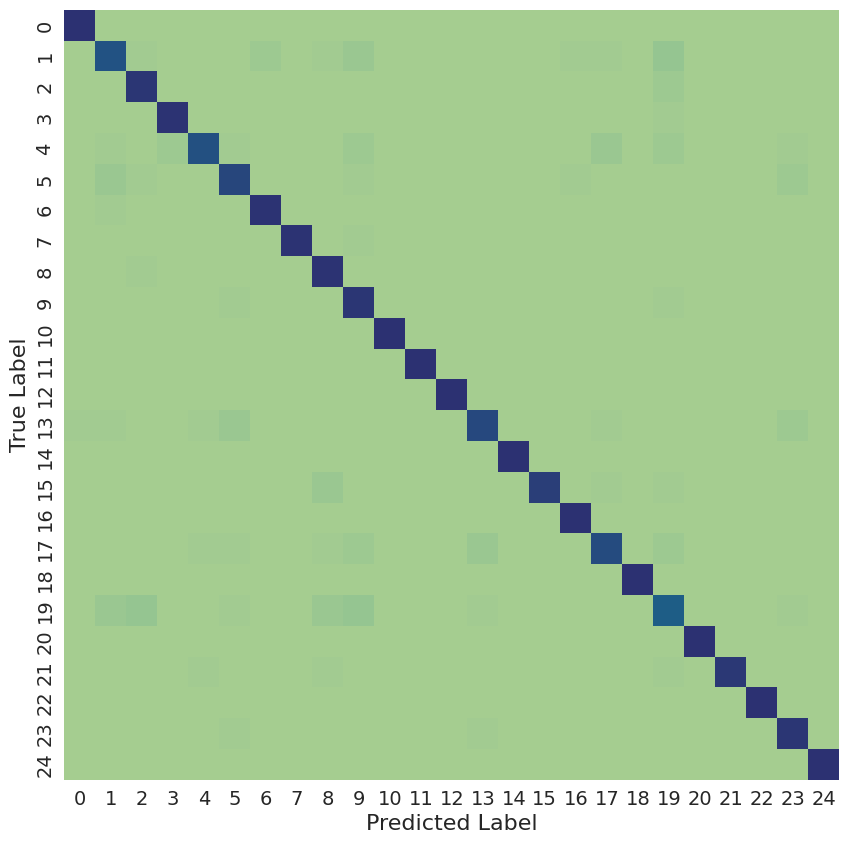

              precision    recall  f1-score   support

    Adposhel       0.99      1.00      0.99        70
       Agent       0.86      0.81      0.84        70
     Allaple       0.91      0.97      0.94        70
   Amonetize       0.97      0.99      0.98        70
      Androm       0.95      0.83      0.89        70
     Autorun       0.89      0.89      0.89        70
   BrowseFox       0.97      0.99      0.98        70
      Dinwod       1.00      0.99      0.99        70
        Elex       0.88      0.99      0.93        70
      Expiro       0.84      0.97      0.90        70
      Fasong       1.00      1.00      1.00        70
     HackKMS       1.00      1.00      1.00        70
        Hlux       1.00      1.00      1.00        70
    Injector       0.92      0.87      0.90        70
 InstallCore       1.00      1.00      1.00        70
   MultiPlug       1.00      0.93      0.96        70
  Neoreklami       0.97      1.00      0.99        70
      Neshta       0.91    

In [ ]:
me.predict()
me.class_report()

Saving essential data

In [ ]:
malevis_models["ResNet50"] = {"Ground Truth": test.labels.tolist(),
                              "Predictions":np.array(me.predictions).tolist(),
                              "History": history.history}


# VGG16
Malimg Dataset

Model Training

In [ ]:
model, history, test = experiment_model(cnns.vgg16,
                                        "malimg",malimg_dir,
                                        (75,75),
                                        cnns.VGG16(include_top=False,
                                                   input_shape=(75, 75, 3)),
                                        25, "validation",
                                        False, 3)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Found 6711 images belonging to 25 classes.
Found 910 images belonging to 25 classes.
Found 1693 images belonging to 25 classes.
Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - accuracy: 0.6736 - auc: 0.8891 - false_positives: 907.1517 - loss: 4.6321 - precision: 0.6760 - recall: 0.6724 - val_accuracy: 0.7857 - val_auc: 0.9254 - val_false_positives: 191.0000 - val_loss: 1.6942 - val_precision: 0.7885 - val_recall: 0.7824
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step - accuracy: 0.8409 - auc: 0.9780 - false_positives: 498.0047 - loss: 0.6199 - precision: 0.8437 - recall: 0.8386 - val_accuracy: 0.8604 - val_auc: 0.9865 - val_false_positives: 124.0000 - val_loss: 0.5503 - val_precision: 0.8633 - val_recall: 0.8604
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step - accuracy: 0.8824 - auc: 0.9923 - false_positives: 384.2465 - loss: 0.3305 - precision: 0.8873 - recall: 0.8794 - val_accuracy: 0.8440 - val_auc: 0.9797 - va

# Model Evaluation
Initialization of evaluator

In [ ]:

me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

Training History

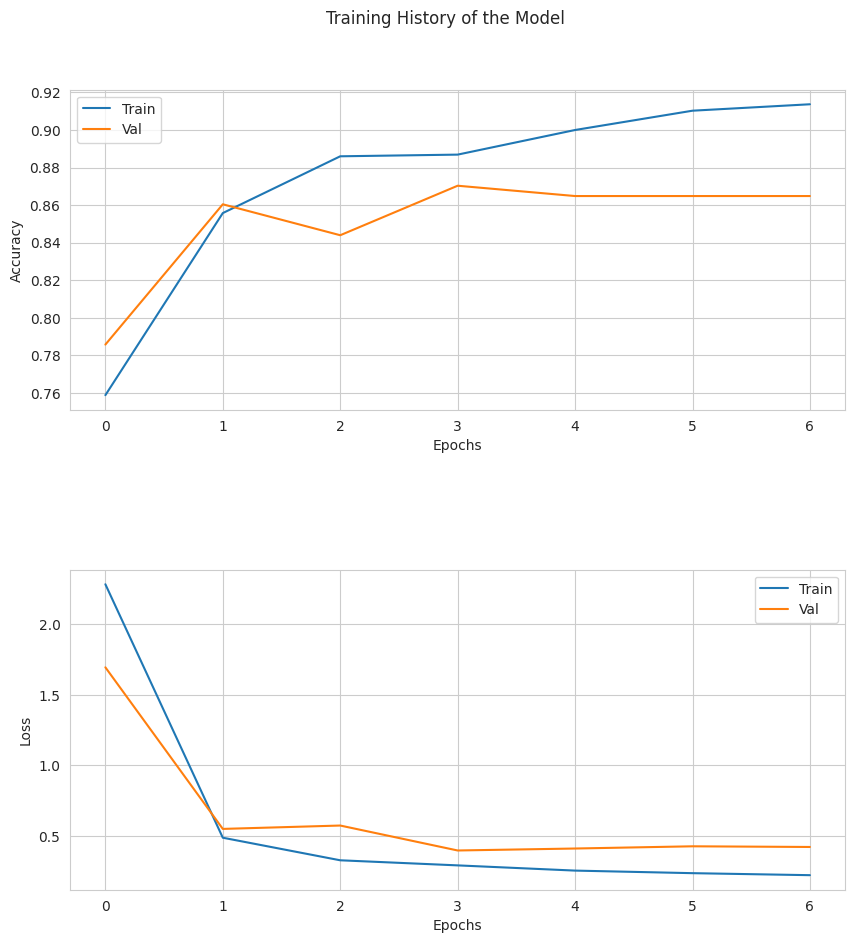

In [ ]:
me.training_history()


Classification Metrics

53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step


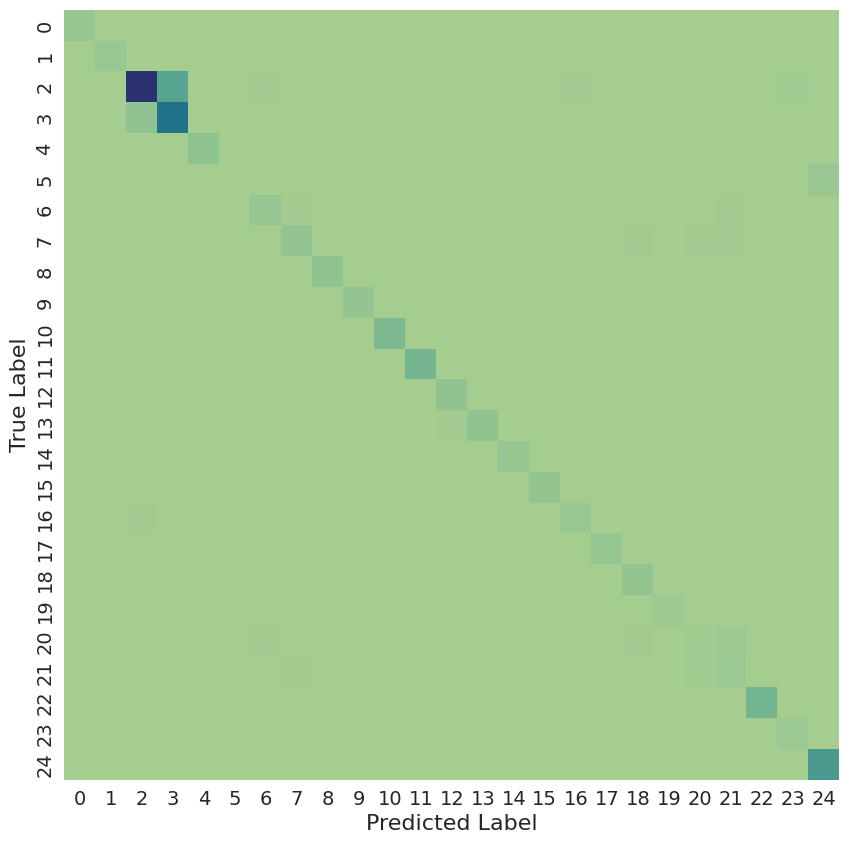

                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        20
     Agent.FYI       1.00      1.00      1.00        19
     Allaple.A       0.93      0.75      0.83       565
     Allaple.L       0.68      0.89      0.77       299
 Alueron.gen!J       1.00      1.00      1.00        35
     Autorun.K       0.00      0.00      0.00        17
       C2LOP.P       0.74      0.80      0.77        25
   C2LOP.gen!g       0.79      0.77      0.78        35
Dialplatform.B       1.00      0.97      0.98        31
     Dontovo.A       1.00      1.00      1.00        28
      Fakerean       0.97      1.00      0.98        62
 Instantaccess       0.99      1.00      0.99        72
    Lolyda.AA1       0.94      1.00      0.97        31
    Lolyda.AA2       0.97      0.94      0.95        32
    Lolyda.AA3       1.00      1.00      1.00        20
     Lolyda.AT       0.93      0.96      0.95        27
   Malex.gen!J       0.86      0.83      0.84  

In [ ]:

me.predict()
me.class_report()

Saving essential data

In [ ]:
malimg_models["VGG16"] = {"Ground Truth": test.labels.tolist(),
                          "Predictions":np.array(me.predictions).tolist(),
                          "History": history.history}

Malevis Dataset

Model Training

In [ ]:

model, history, test = experiment_model(cnns.vgg16,
                                        "malevis",malevis_dir,
                                        (200,200),
                                        cnns.VGG16(include_top=False,
                                                   input_shape=(200, 200, 3)),
                                        25, "val",
                                        False, 8)

Found 7000 images belonging to 25 classes.
Found 3644 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.
Epoch 1/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 88s 332ms/step - accuracy: 0.7494 - auc: 0.8931 - false_positives: 631.8318 - loss: 9.8812 - precision: 0.7574 - recall: 0.7468 - val_accuracy: 0.9212 - val_auc: 0.9869 - val_false_positives: 172.0000 - val_loss: 0.3977 - val_precision: 0.9503 - val_recall: 0.9023
Epoch 2/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 47s 211ms/step - accuracy: 0.9684 - auc: 0.9956 - false_positives: 84.6409 - loss: 0.1701 - precision: 0.9773 - recall: 0.9641 - val_accuracy: 0.9072 - val_auc: 0.9771 - val_false_positives: 287.0000 - val_loss: 0.5484 - val_precision: 0.9197 - val_recall: 0.9015
Epoch 3/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 47s 209ms/step - accuracy: 0.9703 - auc: 0.9949 - false_positives: 97.1682 - loss: 0.1810 - precision: 0.9732 - recall: 0.9678 - val_accuracy: 0.9042 - val_auc: 0.9726 - val_false_positives: 322.0000 - val_loss: 0.7643 - v

Model Evaluation

Initialization of evaluator

In [ ]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

Training History

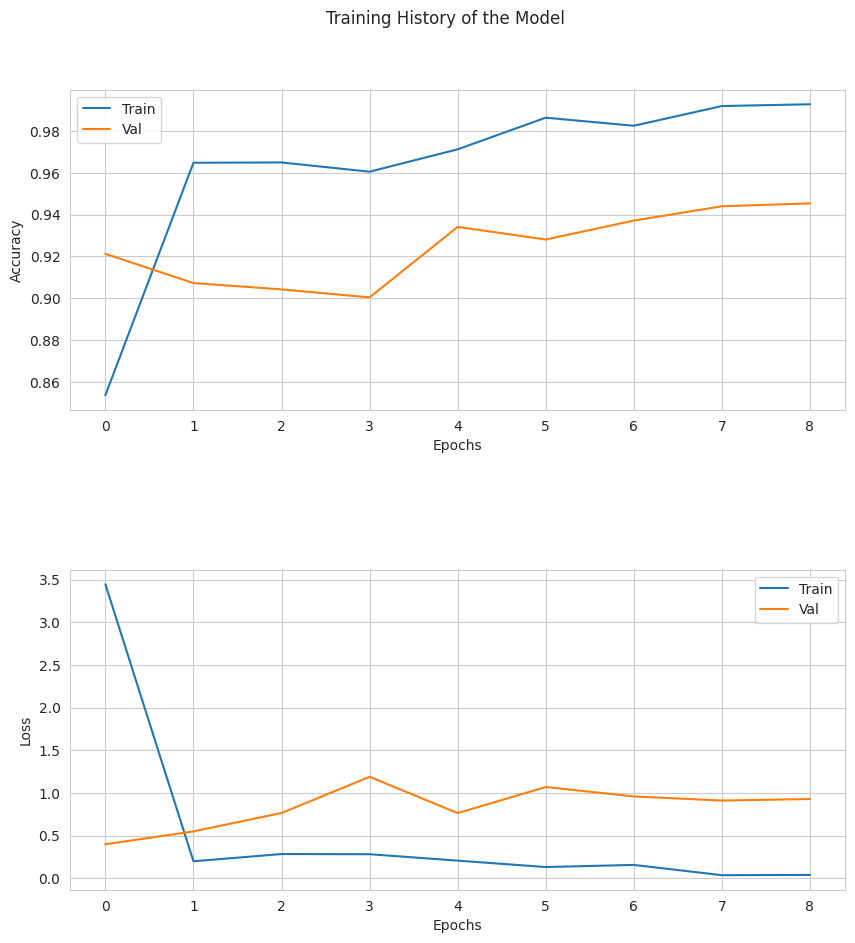

In [ ]:
me.training_history()

Classification Metrics

55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 304ms/step


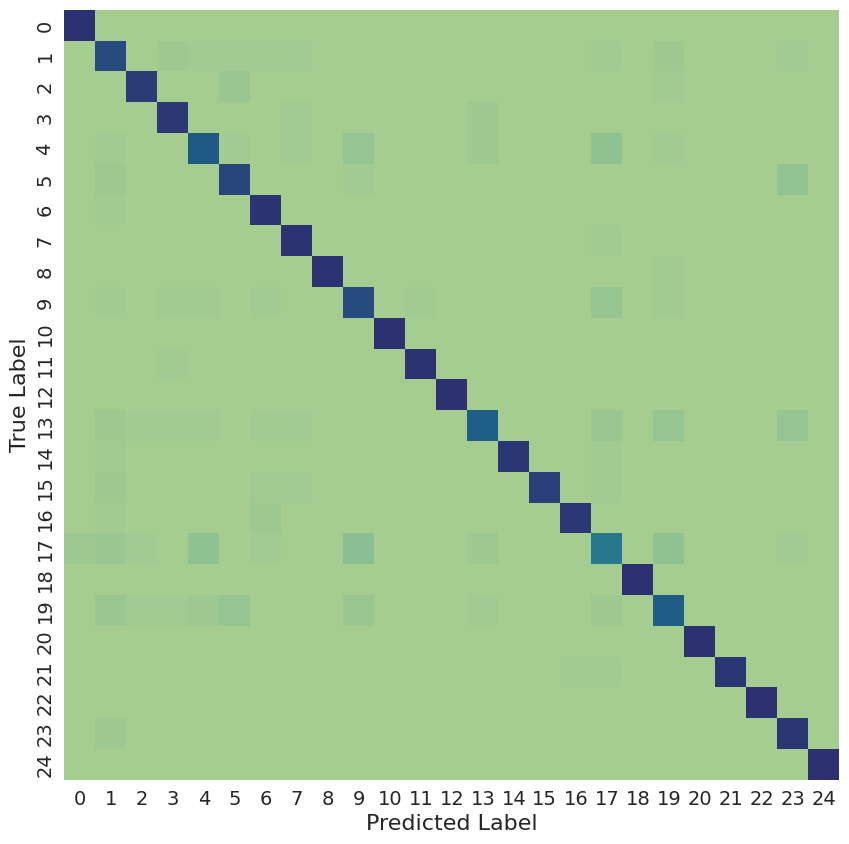

              precision    recall  f1-score   support

    Adposhel       0.97      1.00      0.99        70
       Agent       0.76      0.86      0.81        70
     Allaple       0.96      0.94      0.95        70
   Amonetize       0.92      0.96      0.94        70
      Androm       0.83      0.77      0.80        70
     Autorun       0.87      0.89      0.88        70
   BrowseFox       0.91      0.99      0.95        70
      Dinwod       0.93      0.99      0.96        70
        Elex       1.00      0.99      0.99        70
      Expiro       0.80      0.86      0.83        70
      Fasong       1.00      1.00      1.00        70
     HackKMS       0.99      0.99      0.99        70
        Hlux       1.00      1.00      1.00        70
    Injector       0.88      0.74      0.81        70
 InstallCore       1.00      0.97      0.99        70
   MultiPlug       1.00      0.93      0.96        70
  Neoreklami       0.99      0.96      0.97        70
      Neshta       0.67    

In [ ]:

me.predict()
me.class_report()

Saving essential data

In [ ]:
malevis_models["VGG16"] = {"Ground Truth": test.labels.tolist(),
                           "Predictions":np.array(me.predictions).tolist(),
                           "History": history.history}

# DenseNet

Malimg Dataset

Model Training

In [ ]:
model, history, test = experiment_model(cnns.densenet,
                                        "malimg",malimg_dir,
                                        (75,75),
                                        cnns.DenseNet169(include_top=False,
                                                         input_shape=(75, 75, 3)),
                                        25, "validation",
                                        False, 3)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Found 6711 images belonging to 25 classes.
Found 910 images belonging to 25 classes.
Found 1693 images belonging to 25 classes.
Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 295s 653ms/step - accuracy: 0.6302 - auc: 0.9222 - false_positives: 601.4834 - loss: 2.0957 - precision: 0.7229 - recall: 0.5611 - val_accuracy: 0.7407 - val_auc: 0.9550 - val_false_positives: 222.0000 - val_loss: 1.1035 - val_precision: 0.7511 - val_recall: 0.7363
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.9423 - auc: 0.9960 - false_positives: 171.9526 - loss: 0.1937 - precision: 0.9496 - recall: 0.9335 - val_accuracy: 0.7319 - val_auc: 0.9509 - val_false_positives: 233.0000 - val_loss: 1.3642 - val_precision: 0.7379 - val_recall: 0.7209
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.9473 - auc: 0.9982 - false_positives: 158.0616 - loss: 0.1503 - precision: 0.9534 - recall: 0.9424 - val_accuracy: 0.9044 - val_auc: 0.9792 - v

# Model Evaluation

Initialization of the evaluator

In [ ]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

Training History

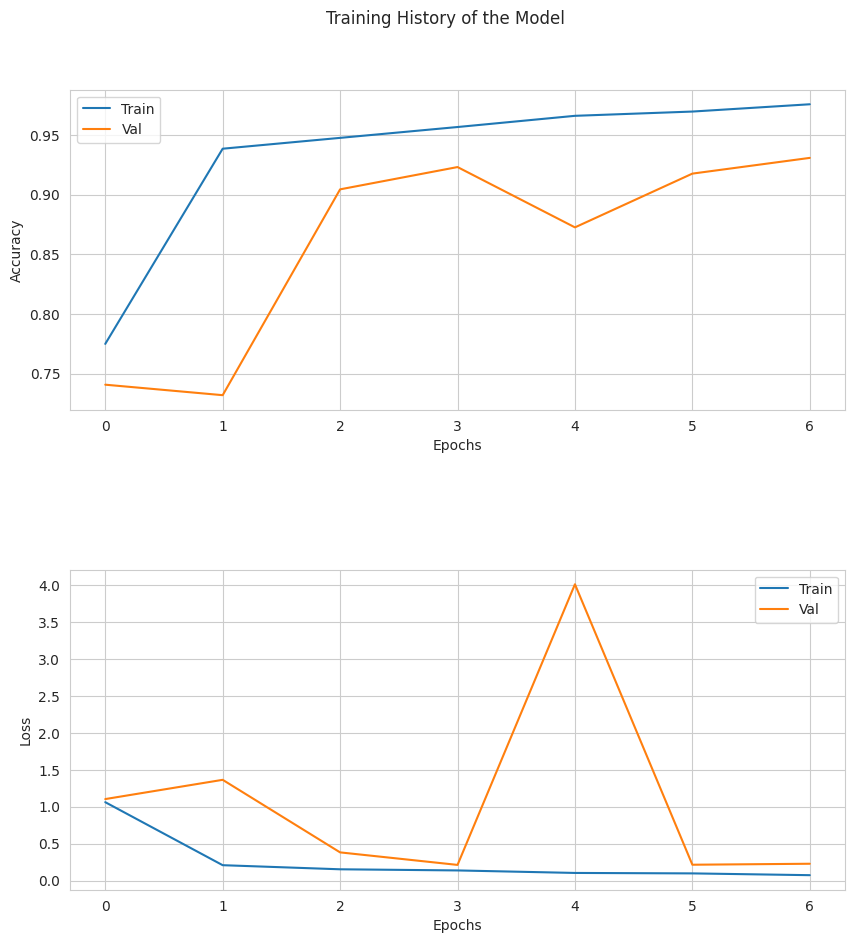

In [ ]:
me.training_history()

Classification Metrics

53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 332ms/step


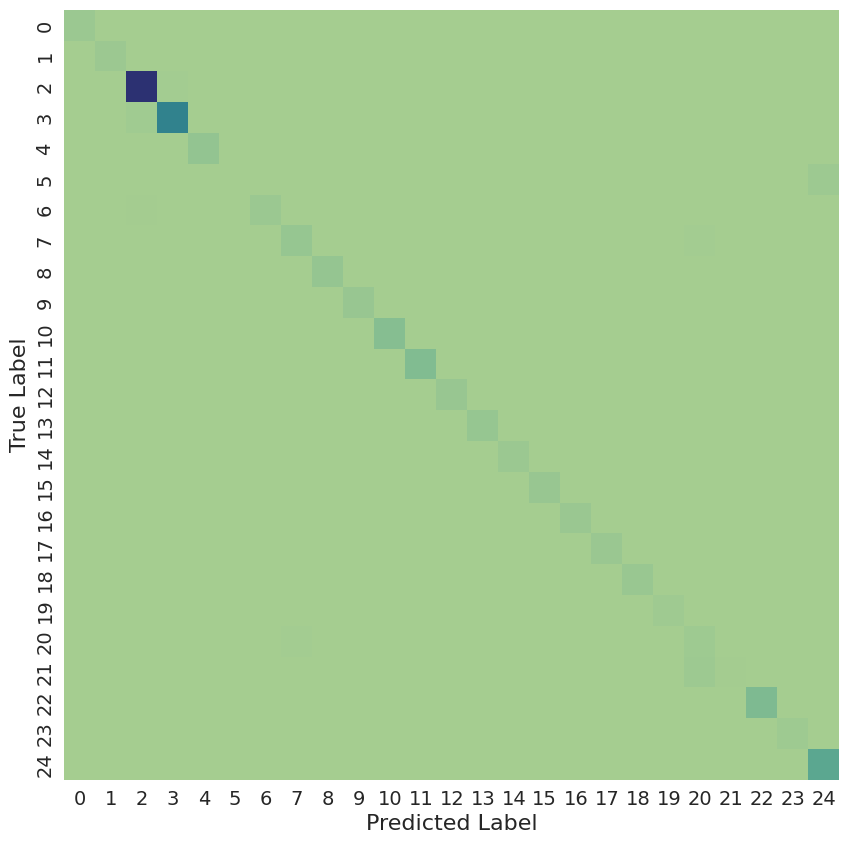

                precision    recall  f1-score   support

     Adialer.C       0.95      1.00      0.98        20
     Agent.FYI       1.00      1.00      1.00        19
     Allaple.A       0.98      0.99      0.98       565
     Allaple.L       0.98      0.97      0.97       299
 Alueron.gen!J       0.97      1.00      0.99        35
     Autorun.K       0.00      0.00      0.00        17
       C2LOP.P       0.87      0.80      0.83        25
   C2LOP.gen!g       0.81      0.86      0.83        35
Dialplatform.B       1.00      1.00      1.00        31
     Dontovo.A       1.00      1.00      1.00        28
      Fakerean       1.00      1.00      1.00        62
 Instantaccess       0.99      1.00      0.99        72
    Lolyda.AA1       0.93      0.87      0.90        31
    Lolyda.AA2       1.00      0.94      0.97        32
    Lolyda.AA3       1.00      1.00      1.00        20
     Lolyda.AT       0.96      1.00      0.98        27
   Malex.gen!J       0.96      0.96      0.96  

In [ ]:
me.predict()
me.class_report()

Saving essential data

In [ ]:
malimg_models["DenseNet169"] = {"Ground Truth": test.labels.tolist(),
                                "Predictions":np.array(me.predictions).tolist(),
                                "History": history.history}

**Malevis Dataset**

Model Training

In [ ]:
model, history, test = experiment_model(cnns.densenet,
                                        "malevis",malevis_dir,
                                        (200,200),
                                        cnns.DenseNet169(include_top=False,
                                                         input_shape=(200, 200, 3)),
                                        25, "val",
                                        False, 8)

Found 7000 images belonging to 25 classes.
Found 3644 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.
Epoch 1/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 391s 952ms/step - accuracy: 0.2425 - auc: 0.6761 - false_positives: 545.8864 - loss: 13.7727 - precision: 0.4495 - recall: 0.1540 - val_accuracy: 0.7324 - val_auc: 0.9516 - val_false_positives: 237.0000 - val_loss: 40.9201 - val_precision: 0.9027 - val_recall: 0.6032
Epoch 2/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 67s 301ms/step - accuracy: 0.7585 - auc: 0.9661 - false_positives: 250.2227 - loss: 2.3996 - precision: 0.9100 - recall: 0.6425 - val_accuracy: 0.8430 - val_auc: 0.9759 - val_false_positives: 280.0000 - val_loss: 0.8824 - val_precision: 0.9140 - val_recall: 0.8167
Epoch 3/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 67s 303ms/step - accuracy: 0.8543 - auc: 0.9793 - false_positives: 251.6500 - loss: 0.7827 - precision: 0.9199 - recall: 0.8163 - val_accuracy: 0.8727 - val_auc: 0.9853 - val_false_positives: 288.0000 - val_loss: 0.488

Model Evaluation

*Initialization of the evaluator*

In [ ]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

Training History

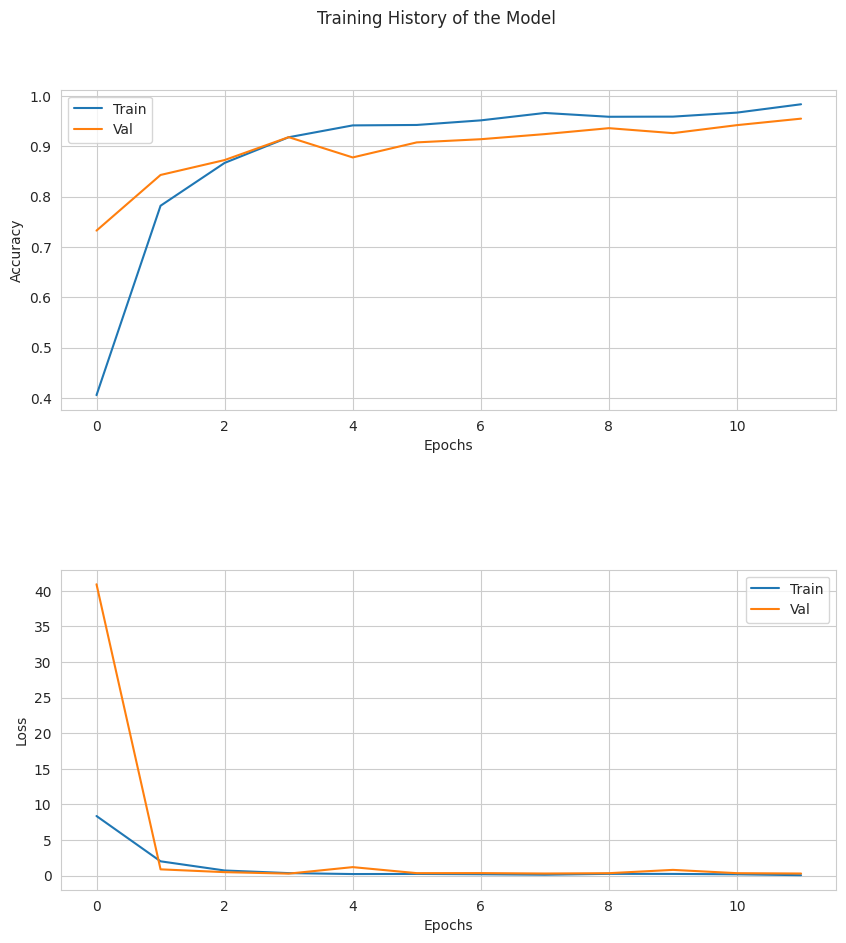

In [ ]:
me.training_history()


Classification Metrics

55/55 ━━━━━━━━━━━━━━━━━━━━ 32s 396ms/step


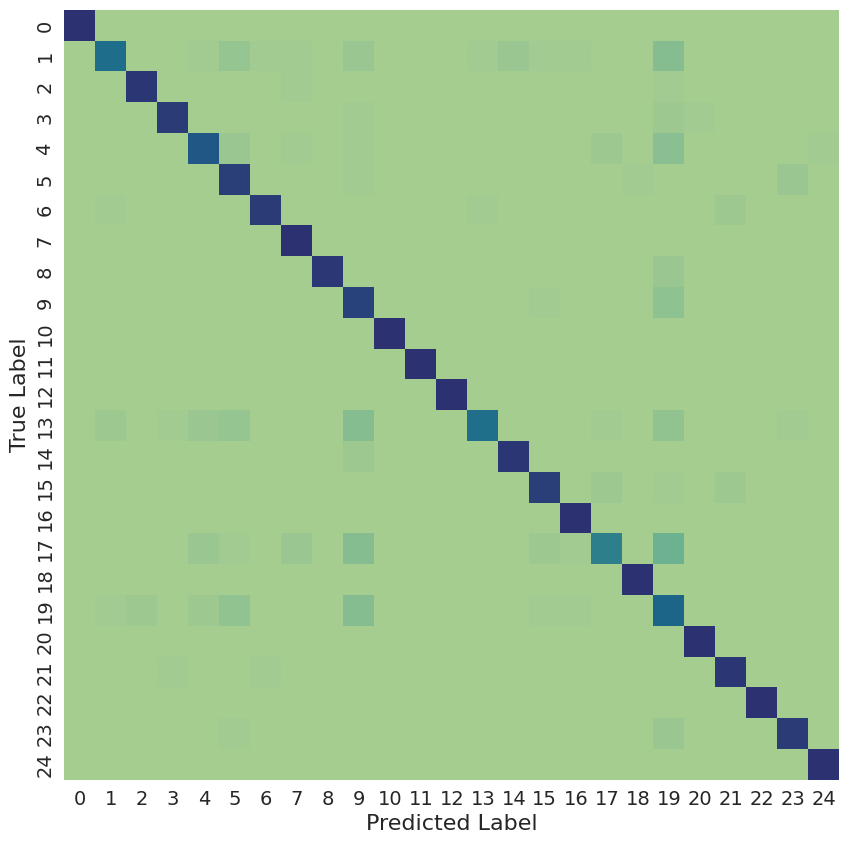

              precision    recall  f1-score   support

    Adposhel       1.00      1.00      1.00        70
       Agent       0.92      0.66      0.77        70
     Allaple       0.97      0.97      0.97        70
   Amonetize       0.97      0.94      0.96        70
      Androm       0.86      0.79      0.82        70
     Autorun       0.78      0.93      0.85        70
   BrowseFox       0.97      0.94      0.96        70
      Dinwod       0.92      1.00      0.96        70
        Elex       1.00      0.96      0.98        70
      Expiro       0.66      0.90      0.76        70
      Fasong       1.00      1.00      1.00        70
     HackKMS       1.00      1.00      1.00        70
        Hlux       1.00      1.00      1.00        70
    Injector       0.96      0.64      0.77        70
 InstallCore       0.96      0.97      0.96        70
   MultiPlug       0.93      0.93      0.93        70
  Neoreklami       0.96      1.00      0.98        70
      Neshta       0.88    

In [ ]:
me.predict()
me.class_report()


Saving essential data

In [ ]:
malevis_models["DenseNet169"] = {"Ground Truth": test.labels.tolist(),
                                 "Predictions":np.array(me.predictions).tolist(),
                                 "History": history.history}


# Inception ResNet V2

Malimg Dataset

Model Training

In [ ]:
model, history, test = experiment_model(cnns.inception_resnet_v2,
                                        "malimg",malimg_dir,
                                        (75,75),
                                        cnns.InceptionResNetV2(include_top=False,
                                                               input_shape=(75, 75, 3)),
                                        25, "validation",
                                        False, 3)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Found 6711 images belonging to 25 classes.
Found 910 images belonging to 25 classes.
Found 1693 images belonging to 25 classes.
Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 202s 401ms/step - accuracy: 0.7024 - auc: 0.9429 - false_positives: 436.5213 - loss: 1.2352 - precision: 0.8002 - recall: 0.6265 - val_accuracy: 0.7604 - val_auc: 0.9641 - val_false_positives: 189.0000 - val_loss: 45.3668 - val_precision: 0.7800 - val_recall: 0.7363
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.9227 - auc: 0.9954 - false_positives: 220.2512 - loss: 0.2426 - precision: 0.9345 - recall: 0.9125 - val_accuracy: 0.8626 - val_auc: 0.9904 - val_false_positives: 116.0000 - val_loss: 0.4009 - val_precision: 0.8702 - val_recall: 0.8549
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.9540 - auc: 0.9983 - false_positives: 144.0569 - loss: 0.1400 - precision: 0.9594 - recall: 0.9517 - val_accuracy: 0.8495 - val_auc: 0.973

# Model Evaluation

Initialization of the evaluator

In [ ]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)

Training History

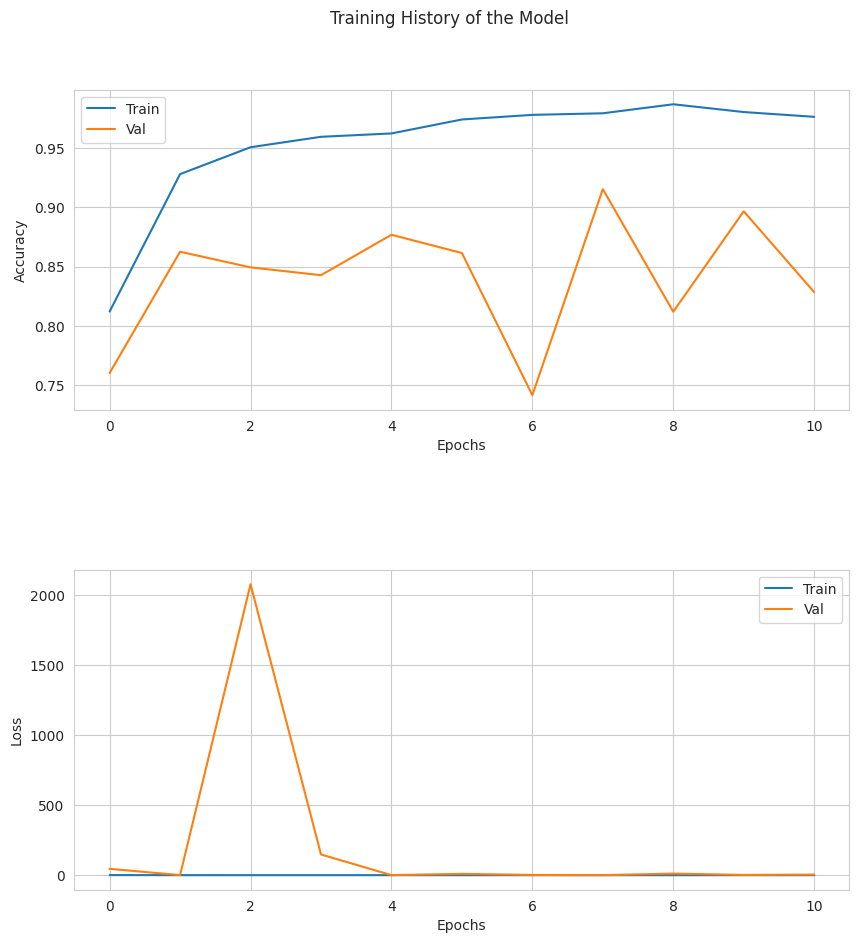

In [ ]:
me.training_history()

Classification Metrics

53/53 ━━━━━━━━━━━━━━━━━━━━ 23s 266ms/step


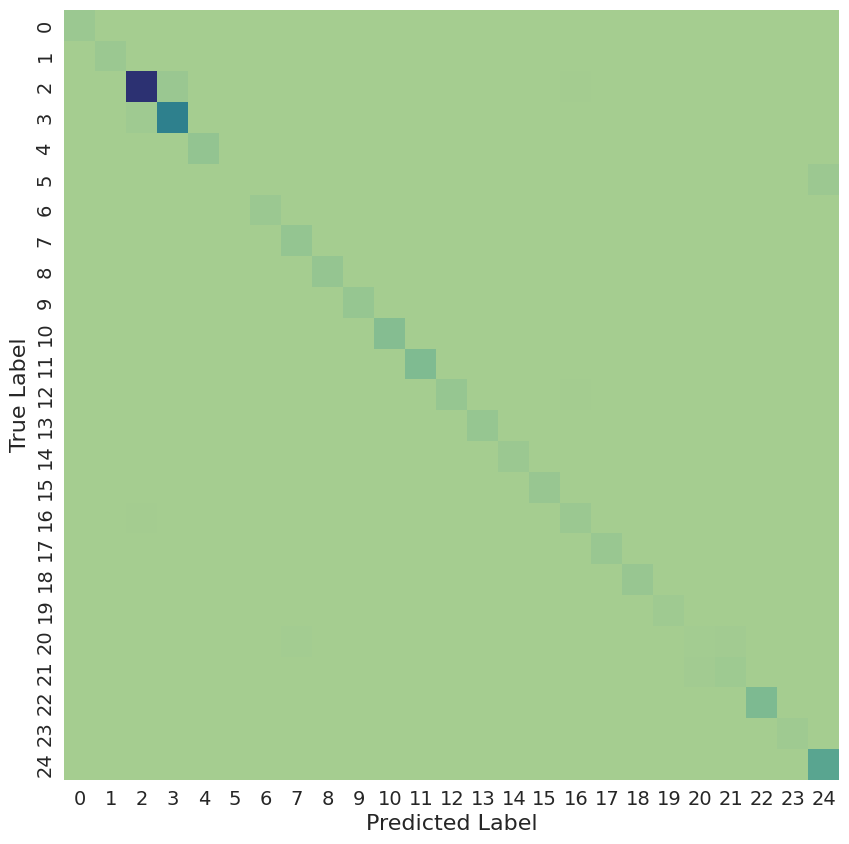

                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        20
     Agent.FYI       1.00      1.00      1.00        19
     Allaple.A       0.97      0.95      0.96       565
     Allaple.L       0.93      0.96      0.94       299
 Alueron.gen!J       0.92      1.00      0.96        35
     Autorun.K       0.00      0.00      0.00        17
       C2LOP.P       0.80      0.80      0.80        25
   C2LOP.gen!g       0.82      0.91      0.86        35
Dialplatform.B       1.00      0.97      0.98        31
     Dontovo.A       1.00      1.00      1.00        28
      Fakerean       1.00      1.00      1.00        62
 Instantaccess       1.00      1.00      1.00        72
    Lolyda.AA1       0.93      0.90      0.92        31
    Lolyda.AA2       1.00      0.91      0.95        32
    Lolyda.AA3       1.00      1.00      1.00        20
     Lolyda.AT       1.00      0.96      0.98        27
   Malex.gen!J       0.71      0.87      0.78  

In [ ]:
me.predict()
me.class_report()

Saving essential data

In [ ]:
malimg_models["InceptionResNetV2"] = {"Ground Truth": test.labels.tolist(),
                                      "Predictions":np.array(me.predictions).tolist(),
                                      "History": history.history}

**Malevis Dataset**

Model Training

In [ ]:
model, history, test = experiment_model(cnns.inception_resnet_v2,
                                        "malevis",malevis_dir, (200,200),
                                        cnns.InceptionResNetV2(include_top=False, input_shape=(200, 200, 3)),
                                        25, "val", False, 8)

Found 7000 images belonging to 25 classes.
Found 3644 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.
Epoch 1/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 312s 806ms/step - accuracy: 0.3904 - auc: 0.8033 - false_positives: 266.3227 - loss: 4.3281 - precision: 0.7245 - recall: 0.2368 - val_accuracy: 0.6803 - val_auc: 0.9443 - val_false_positives: 153.0000 - val_loss: 42.1954 - val_precision: 0.9153 - val_recall: 0.4539
Epoch 2/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 96s 435ms/step - accuracy: 0.8061 - auc: 0.9759 - false_positives: 283.0000 - loss: 0.8487 - precision: 0.9061 - recall: 0.7352 - val_accuracy: 0.8633 - val_auc: 0.9885 - val_false_positives: 160.0000 - val_loss: 0.5053 - val_precision: 0.9482 - val_recall: 0.8043
Epoch 3/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 95s 431ms/step - accuracy: 0.9135 - auc: 0.9921 - false_positives: 172.6636 - loss: 0.3212 - precision: 0.9470 - recall: 0.8888 - val_accuracy: 0.8987 - val_auc: 0.9855 - val_false_positives: 173.0000 - val_loss: 1.7863

Model Evaluation

Initialization of the evaluator

In [ ]:
me = ModelEvaluator(history, list(test.class_indices.keys()), model, test)


Training History

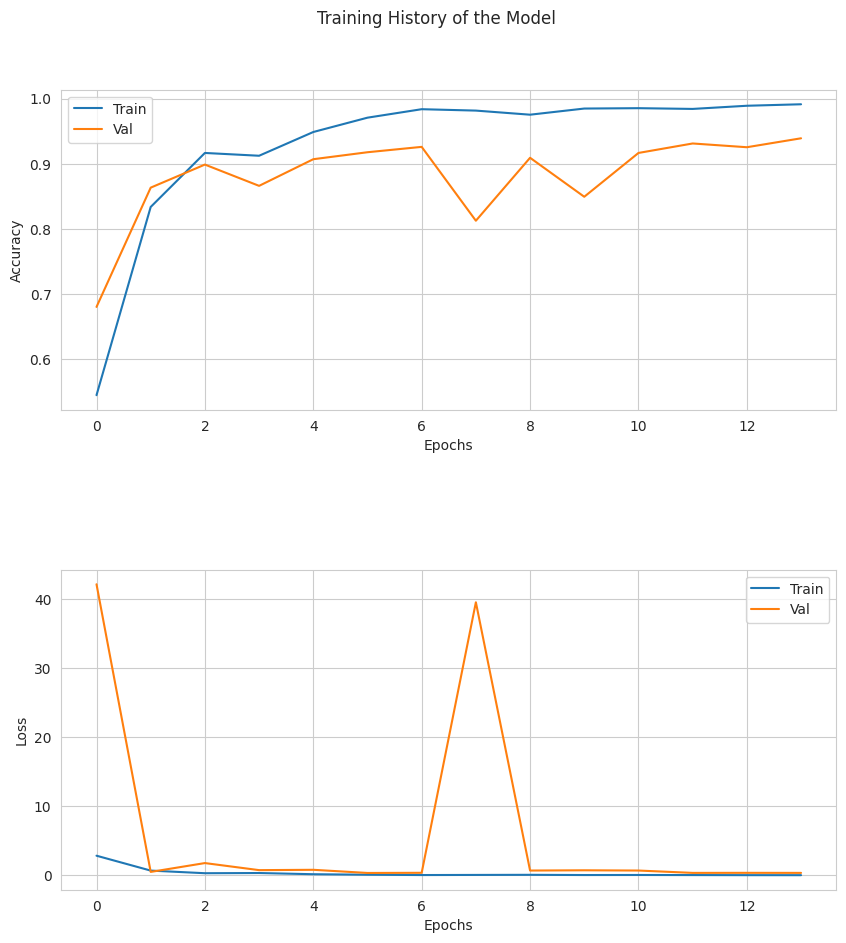

In [ ]:
me.training_history()


Classification Metrics

55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 328ms/step


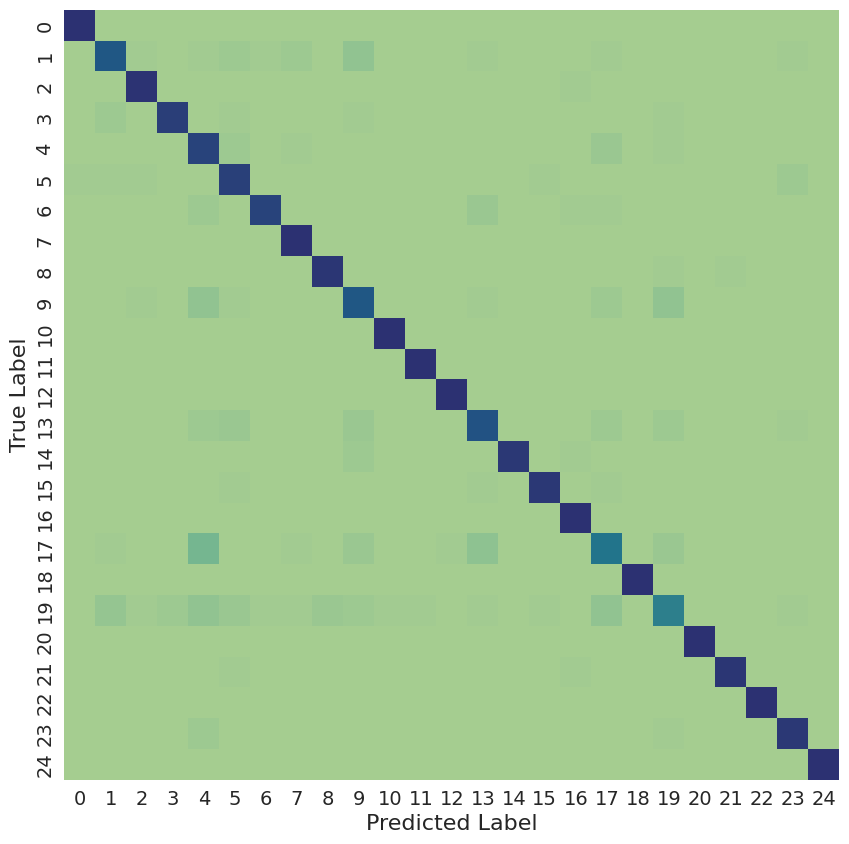

              precision    recall  f1-score   support

    Adposhel       0.99      1.00      0.99        70
       Agent       0.87      0.79      0.83        70
     Allaple       0.95      0.99      0.97        70
   Amonetize       0.97      0.93      0.95        70
      Androm       0.68      0.90      0.78        70
     Autorun       0.82      0.91      0.86        70
   BrowseFox       0.97      0.90      0.93        70
      Dinwod       0.93      1.00      0.97        70
        Elex       0.96      0.97      0.96        70
      Expiro       0.77      0.79      0.78        70
      Fasong       0.99      1.00      0.99        70
     HackKMS       0.99      1.00      0.99        70
        Hlux       0.99      1.00      0.99        70
    Injector       0.81      0.81      0.81        70
 InstallCore       1.00      0.96      0.98        70
   MultiPlug       0.97      0.96      0.96        70
  Neoreklami       0.95      1.00      0.97        70
      Neshta       0.74    

In [ ]:
me.predict()
me.class_report()

Saving the essential data

In [ ]:
malevis_models["InceptionResNetV2"] = {"Ground Truth": test.labels.tolist(),
                                       "Predictions":np.array(me.predictions).tolist(),
                                       "History": history.history}

# Saving the model related information

In [ ]:
# Serializing the model information for malimg dataset.
with open("/content/drive/MyDrive/malimg_models.json", 'w') as fp:
    json.dump(malimg_models, fp)


# Serializing the model information for malevis dataset.
with open("/content/drive/MyDrive/malevis_models.json", 'w') as fp:
    json.dump(malevis_models, fp)

# Model-wise Comparison

In [ ]:
# A class for model performance comparison for the particular dataset.
class ModelComparison:

    # Initialization of the class using the required parameters.
    def __init__(self, json_file_path : str, dataset : str):
        self.history = json.load(open(json_file_path, "r"))
        self.dataset = dataset
        self.colors = ["red", "orange", "yellow", "green", "blue", "black"]
        self.models = ['XceptionNet', 'EfficientNetB0', 'ResNet50', 'VGG16', 'DenseNet169', 'InceptionResNetV2']

    # Plotting a particular metric for all models.
    def __plot_metric(self, ax, metric: str):

        for model_idx in range(0, len(self.models)):
            ax.plot(self.history[self.models[model_idx]]["History"][metric],
                    color=self.colors[model_idx])

        ax.title.set_text(metric + " Comparison")
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.title())
        ax.legend(self.models)

    # Plotting the comparative analysis of models based on
    # training history.
    def training_history(self):
        rows = 3
        columns = 2
        c = 0
        metrics = ["loss", "accuracy", "auc", "false_positives", "precision", "recall"]
        fig, axs = plt.subplots(rows, columns,
                                figsize=(15,15))

        for metric in metrics:
            self.__plot_metric(axs[c//columns, c%columns],
                               metric)
            c += 1

        fig.suptitle("Comparison of Model Performance on "+self.dataset)
        plt.subplots_adjust(bottom=0.1,
                            top=0.9, hspace=0.5)
        plt.show()

    # Model Comparison based on Classification metrics.
    def compare_performance(self):
        accuracy = []
        f1 = []
        recall = []
        precision = []
        x = np.arange(len(self.models))

        for model_idx in range(0, len(self.models)):
            ground_truth = self.history[self.models[model_idx]]["Ground Truth"]
            predictions = self.history[self.models[model_idx]]["Predictions"]
            accuracy.append(round(accuracy_score(ground_truth, predictions),2))
            f1.append(round(f1_score(ground_truth,
                                     predictions,
                                     average="weighted"),
                            2))
            recall.append(round(recall_score(ground_truth,
                                             predictions,
                                             average="weighted"),
                                2))
            precision.append(round(precision_score(ground_truth,
                                                   predictions,
                                                   average="weighted"),
                                    2))

        plt.figure(figsize=(15,8))

        b1 = plt.bar(x, accuracy, 0.2,
                     label = 'Accuracy',
                     color="crimson",
                     edgecolor="black")
        plt.bar_label(b1, accuracy)
        b2 = plt.bar(x+0.2, f1, 0.2,
                     label = 'F1-score',
                     color="yellow",
                     edgecolor="black")
        plt.bar_label(b2, f1)
        b3 = plt.bar(x+0.4, recall, 0.2,
                     label = 'Recall',
                     color="orange",
                     edgecolor="black")
        plt.bar_label(b3, recall)
        b4 = plt.bar(x+0.6, precision, 0.2,
                     label = 'Precision',
                     color="blue",
                     edgecolor="black")
        plt.bar_label(b4, precision)

        plt.xticks(x+0.3, self.models)
        plt.xlabel("Models")
        plt.ylabel("Classification Metrics")
        plt.title("Classification Metrics for "+self.dataset+" across all models")
        plt.legend(loc='lower right')
        plt.show()

**Malimg Dataset**

In [ ]:
malimg_model_comp = ModelComparison("/content/drive/MyDrive/malimg_models.json",
                                    "Malimg dataset")

# Training History Comparison

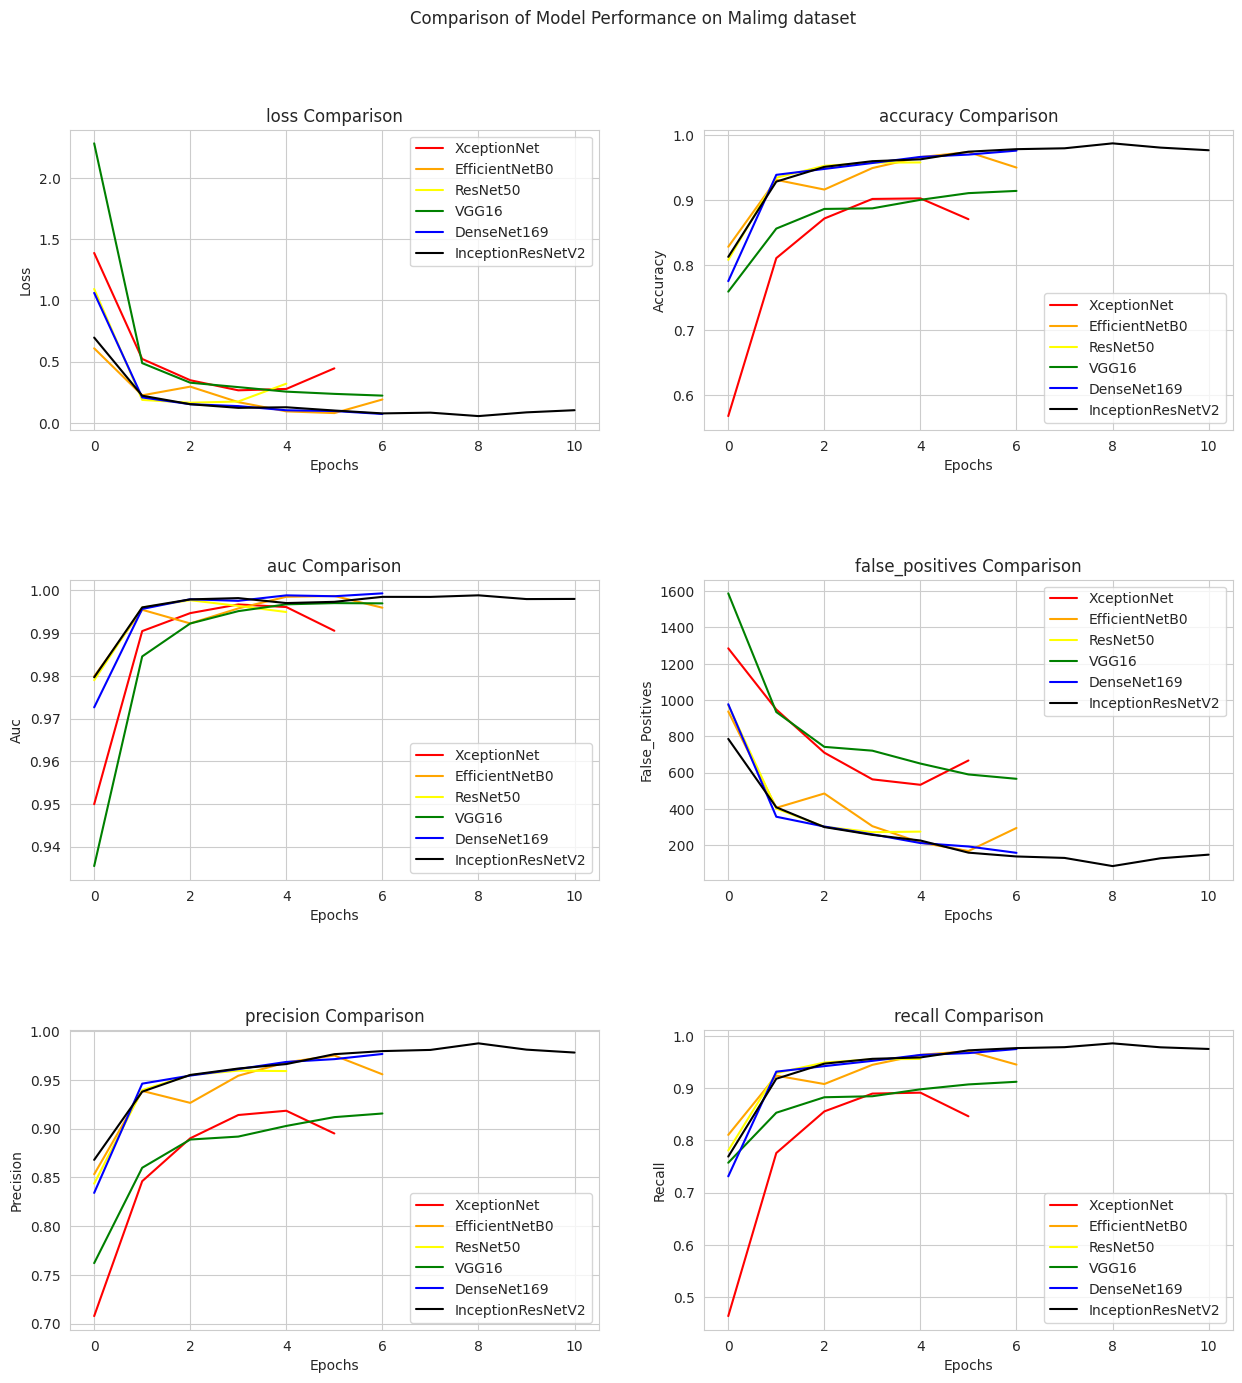

In [ ]:
malimg_model_comp.training_history()

Classification Metrics-based comparison

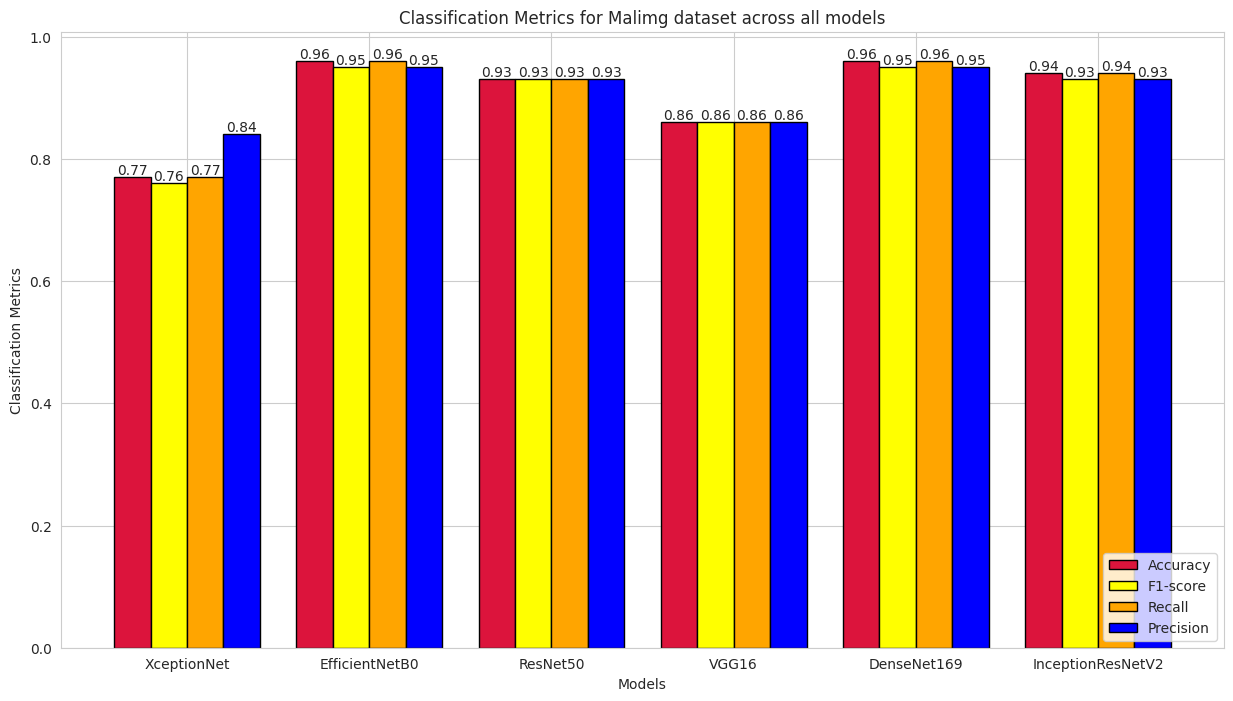

In [ ]:
malimg_model_comp.compare_performance()

**Malevis Dataset**

In [ ]:
malevis_model_comp = ModelComparison("/content/drive/MyDrive/malevis_models.json",
                                     "Malevis dataset")

Training History Comparison

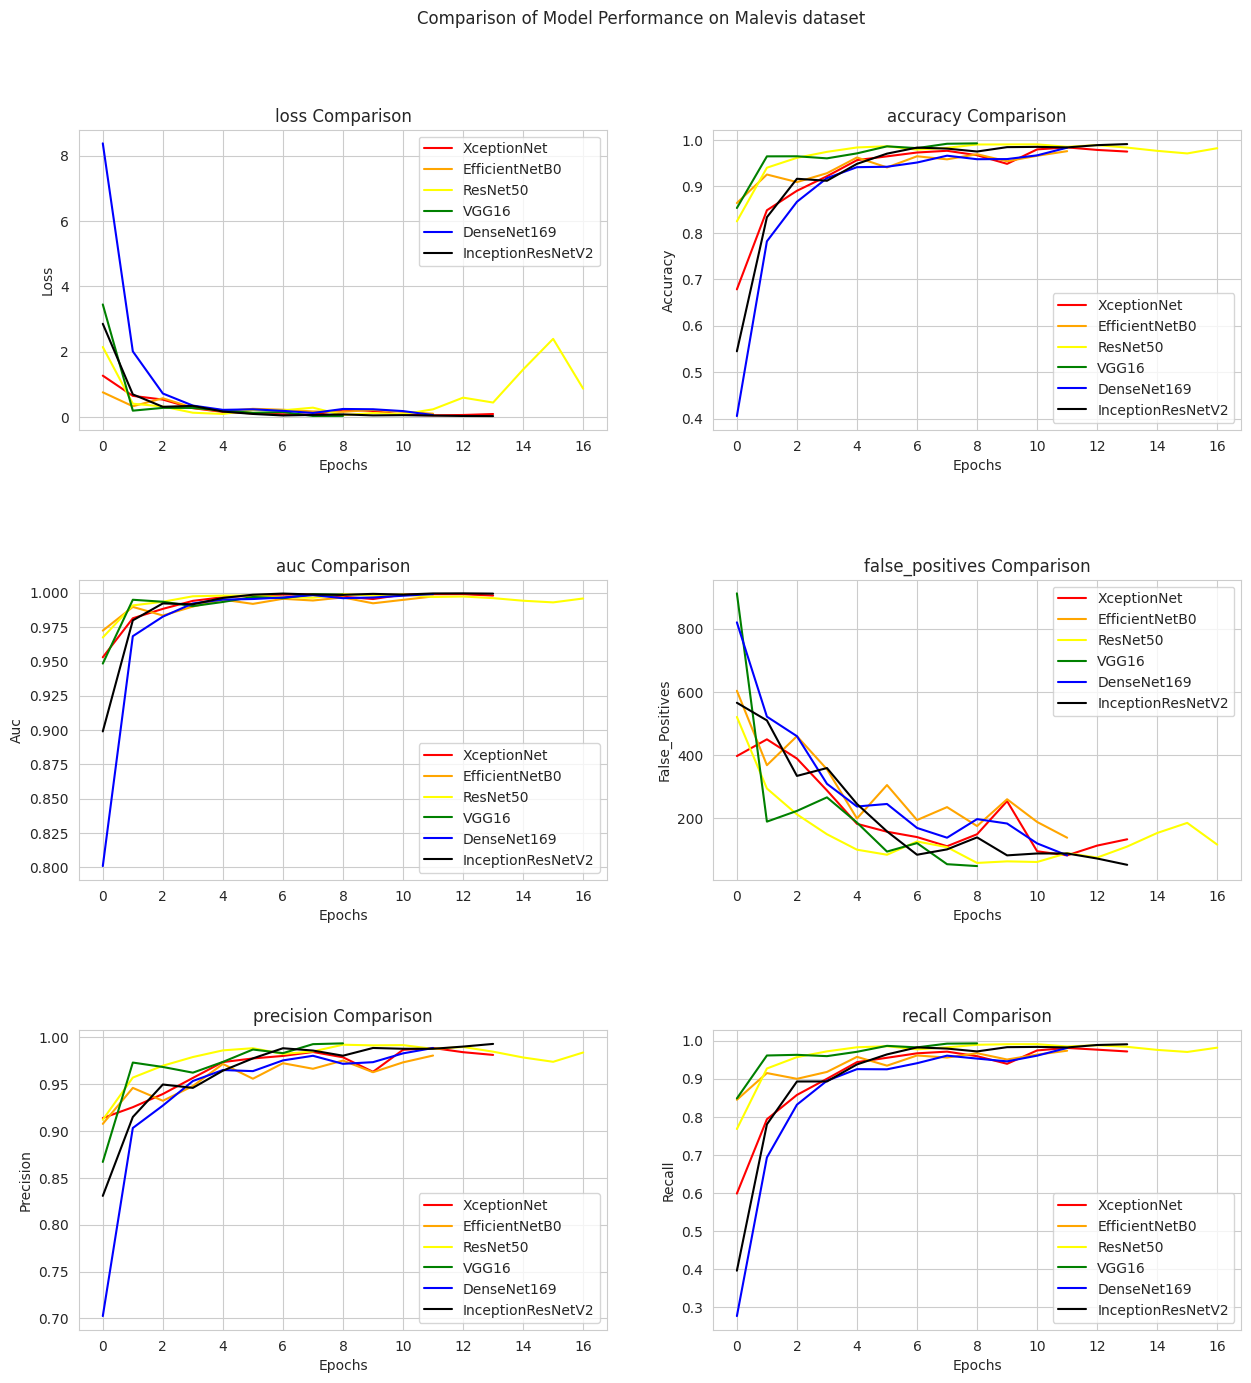

In [ ]:
malevis_model_comp.training_history()


Classification Metrics-based comparison

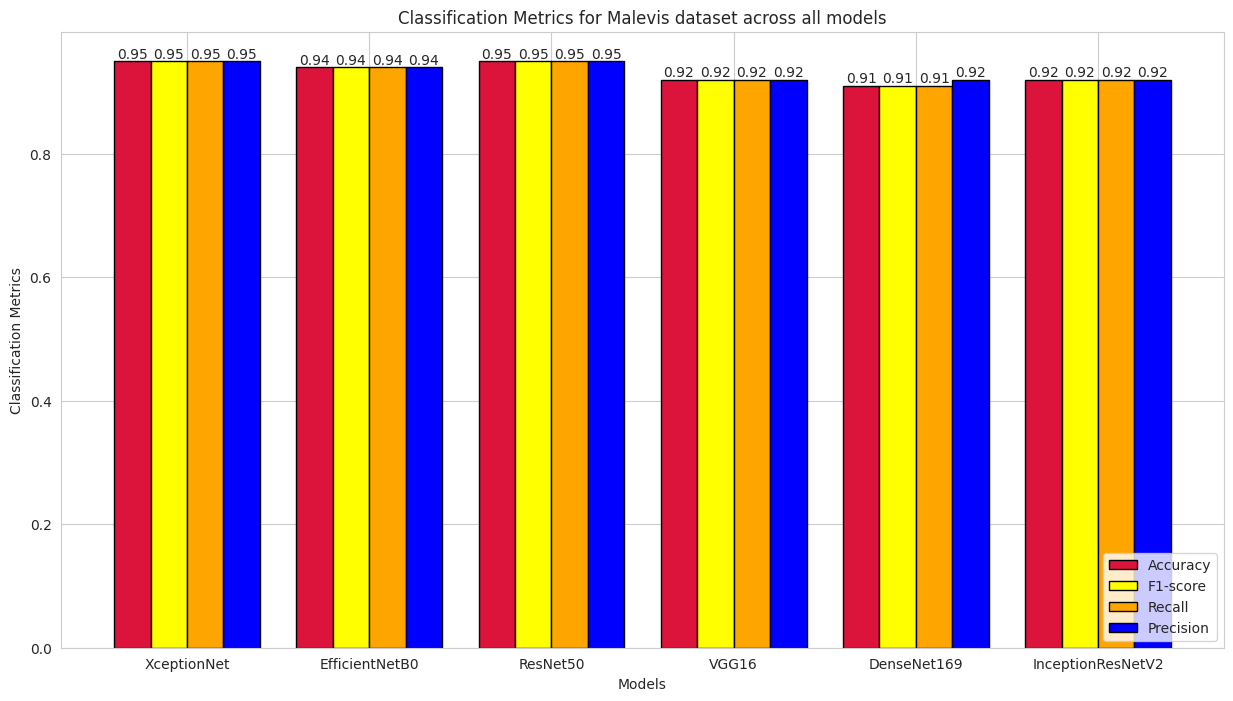

In [ ]:
malevis_model_comp.compare_performance()